In [2]:
!pip install ccxt tensorflow scikit-learn matplotlib seaborn pandas numpy scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 51.2 MB/s eta 0:00:00


In [3]:
import ccxt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, Dense, BatchNormalization, Dropout,
                                   Activation, Bidirectional, GRU, GlobalMaxPooling1D)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [11]:
def fetch_ohlcv(exchange, symbol, timeframe='1h', since=None, limit=1000):
    """Fetch OHLCV data from exchange"""
    all_data = []
    while True:
        try:
            data = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
            if not data:
                break
            all_data.extend(data)
            since = data[-1][0] + 1
            if len(data) < limit:
                break
        except Exception as e:
            print(f"Error fetching data: {e}")
            break

    if not all_data:
        return pd.DataFrame()

    df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

def load_crypto_data():
    """Load data for BTC, CHZ, and SUI"""
    exchange = ccxt.bitfinex()

    # Calculate time range (8 months ago to ensure enough data)
    now = exchange.milliseconds()
    eight_months_ago = now - 8 * 30 * 24 * 60 * 60 * 1000

    # Load data for each cryptocurrency
    symbols = ['BTC/USDT', 'CHZ/USDT', 'SUI/USDT']
    crypto_data = {}

    for symbol in symbols:
        print(f"Loading {symbol} data...")
        try:
            data = fetch_ohlcv(exchange, symbol, since=eight_months_ago)
            if not data.empty:
                crypto_name = symbol.split('/')[0]
                crypto_data[crypto_name] = data
                print(f"{crypto_name}: {len(data)} records loaded")
            else:
                print(f"No data found for {symbol}")
        except Exception as e:
            print(f"Error loading {symbol}: {e}")

    return crypto_data

# Load all cryptocurrency data
print("Loading cryptocurrency data...")
crypto_data = load_crypto_data()
print(f"Loaded data for {len(crypto_data)} cryptocurrencies")

Loading cryptocurrency data...
Loading BTC/USDT data...
BTC: 5760 records loaded
Loading CHZ/USDT data...
CHZ: 4510 records loaded
Loading SUI/USDT data...
SUI: 5488 records loaded
Loaded data for 3 cryptocurrencies


BTC processed data shape: (5736, 9)
BTC date range: 2024-10-13 09:00:00 to 2025-06-09 08:00:00
CHZ processed data shape: (4486, 9)
CHZ date range: 2024-10-13 11:00:00 to 2025-06-09 02:00:00
SUI processed data shape: (5464, 9)
SUI date range: 2024-10-13 09:00:00 to 2025-06-09 08:00:00


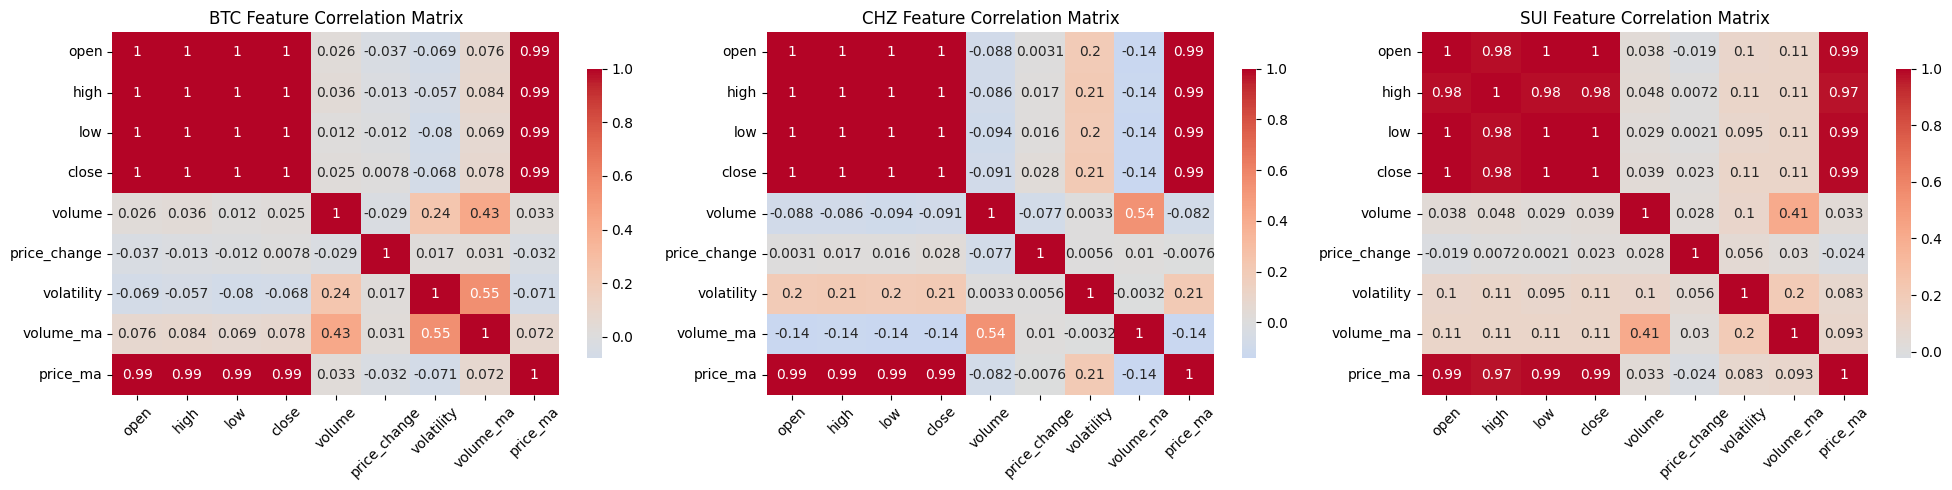

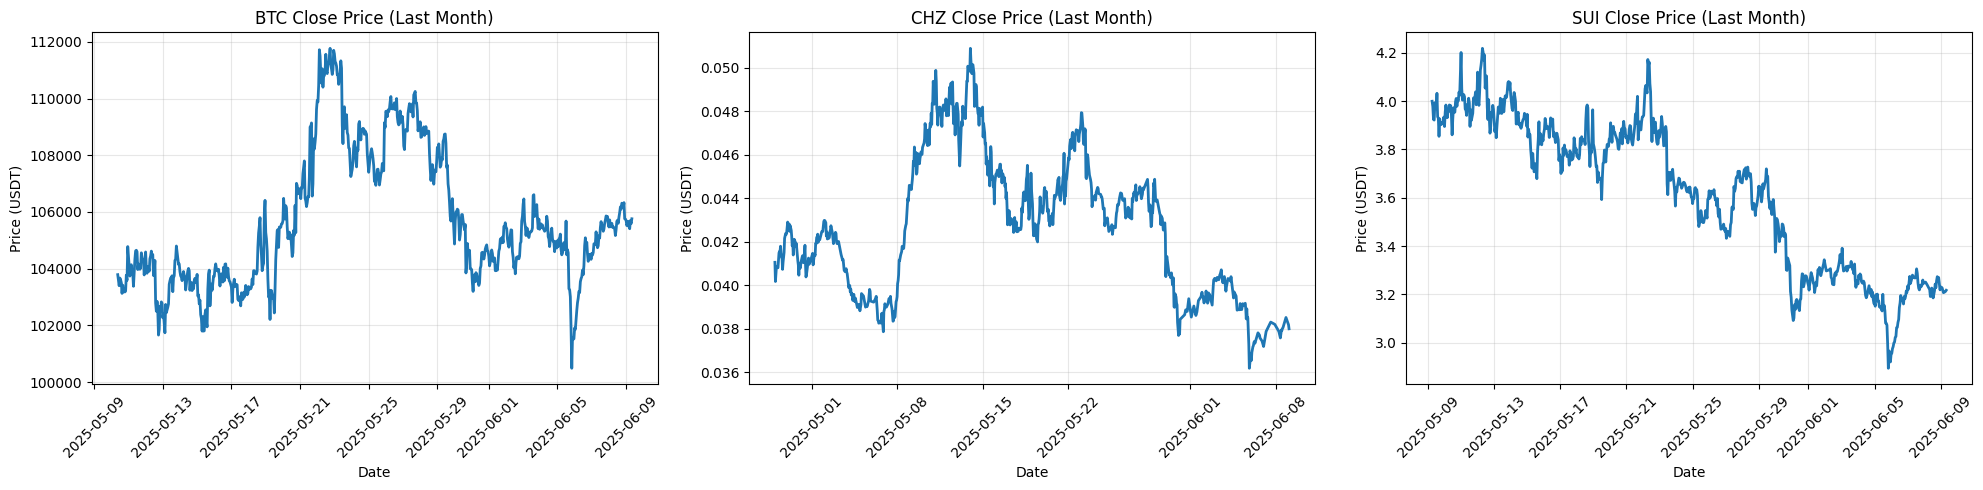

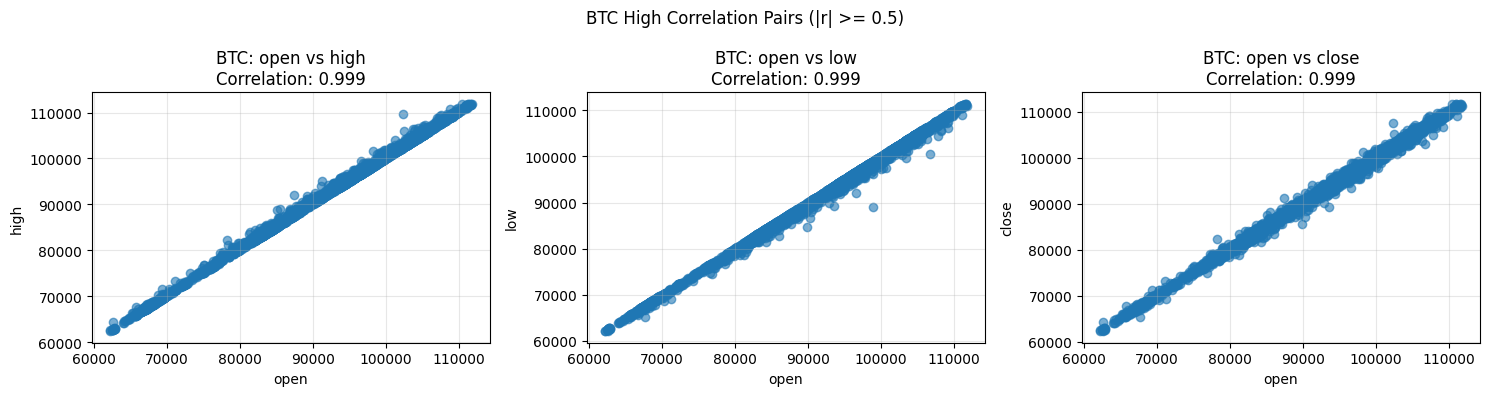

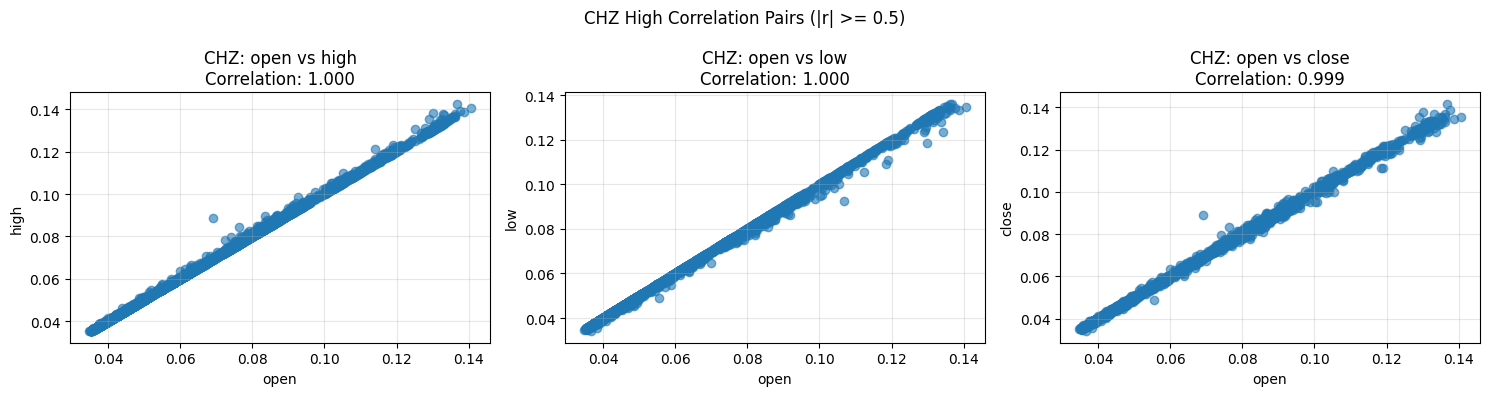

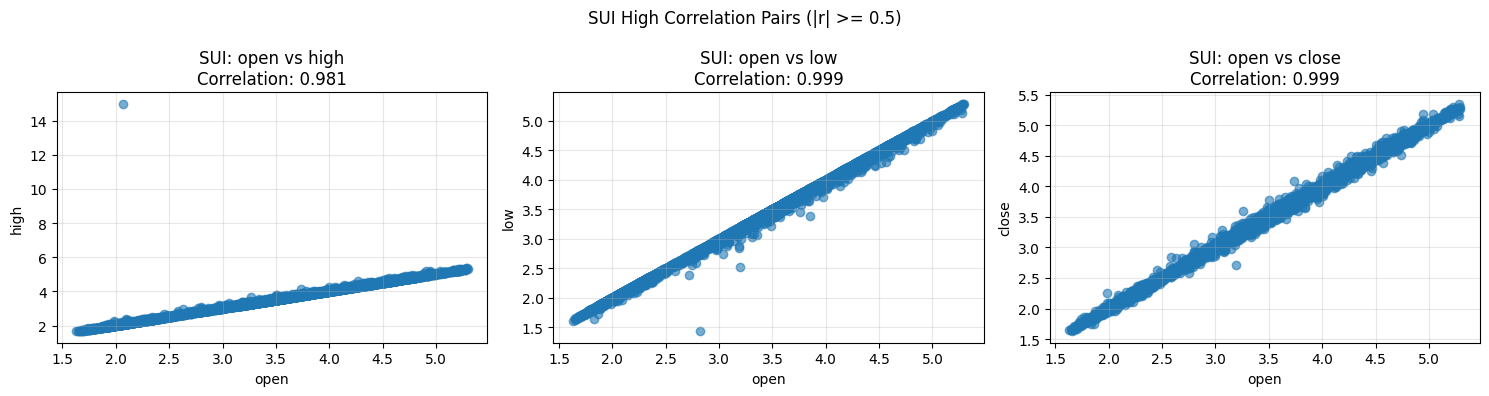

In [12]:
def preprocess_data(df):
    """Add technical indicators and prepare data"""
    df = df.copy()

    # Add technical indicators
    df['price_change'] = df['close'].pct_change()
    df['volatility'] = df['price_change'].rolling(window=24).std()
    df['volume_ma'] = df['volume'].rolling(window=24).mean()
    df['price_ma'] = df['close'].rolling(window=24).mean()

    # Remove NaN values
    df = df.dropna()

    return df

# Preprocess all data
processed_data = {}
for coin, data in crypto_data.items():
    processed_data[coin] = preprocess_data(data)
    print(f"{coin} processed data shape: {processed_data[coin].shape}")
    print(f"{coin} date range: {processed_data[coin].index.min()} to {processed_data[coin].index.max()}")

# Visualization 1: Correlation Heatmaps
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, (coin, data) in enumerate(processed_data.items()):
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                ax=axes[i], cbar_kws={'shrink': .8})
    axes[i].set_title(f'{coin} Feature Correlation Matrix')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Visualization 2: Recent Close Prices (last month of data)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, (coin, data) in enumerate(processed_data.items()):
    # Get last month of data
    last_month_data = data.tail(30*24)  # Last 30 days (24 hours each)
    axes[i].plot(last_month_data.index, last_month_data['close'], linewidth=2)
    axes[i].set_title(f'{coin} Close Price (Last Month)')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price (USDT)')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualization 3: High Correlation Scatter Plots
for coin, data in processed_data.items():
    corr_matrix = data.corr()
    high_corr_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= 0.5:
                col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
                corr_val = corr_matrix.iloc[i, j]
                high_corr_pairs.append((col1, col2, corr_val))

    if high_corr_pairs:
        n_pairs = len(high_corr_pairs)
        fig, axes = plt.subplots(1, min(n_pairs, 3), figsize=(15, 4))
        if n_pairs == 1:
            axes = [axes]

        for idx, (col1, col2, corr_val) in enumerate(high_corr_pairs[:3]):
            ax = axes[idx] if n_pairs > 1 else axes[0]
            ax.scatter(data[col1], data[col2], alpha=0.6)
            ax.set_xlabel(col1)
            ax.set_ylabel(col2)
            ax.set_title(f'{coin}: {col1} vs {col2}\nCorrelation: {corr_val:.3f}')
            ax.grid(True, alpha=0.3)

        plt.suptitle(f'{coin} High Correlation Pairs (|r| >= 0.5)')
        plt.tight_layout()
        plt.show()

In [13]:
def prepare_data_feature(df, feature, start_date, end_date, window_size=24):
    """Prepare feature data for model training"""
    try:
        # Convert dates to datetime if they're strings
        if isinstance(start_date, str):
            start_date = pd.to_datetime(start_date)
        if isinstance(end_date, str):
            end_date = pd.to_datetime(end_date)

        # Filter data for the date range
        mask = (df.index >= start_date) & (df.index <= end_date)
        data = df.loc[mask, [feature]]

        if len(data) < window_size + 1:
            print(f"Not enough data for {feature}: {len(data)} records")
            return np.array([]), np.array([]), MinMaxScaler()

        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data)

        X, y = [], []
        for i in range(window_size, len(data_scaled)):
            X.append(data_scaled[i-window_size:i])
            y.append(data_scaled[i, 0])

        X, y = np.array(X), np.array(y)
        return X, y, scaler
    except Exception as e:
        print(f"Error preparing data for {feature}: {e}")
        return np.array([]), np.array([]), MinMaxScaler()

In [14]:
def build_cnn_dnn(input_shape):
    """CNN + DNN model"""
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(50, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_cnn_bigru(input_shape):
    """CNN + BiGRU model"""
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Bidirectional(GRU(50, activation='relu')),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_tcn_dnn(input_shape):
    """TCN + DNN model (simplified as dilated CNN)"""
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu', input_shape=input_shape),
        Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu'),
        Conv1D(filters=32, kernel_size=3, dilation_rate=4, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(50, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_tcn_bigru(input_shape):
    """TCN + BiGRU model"""
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu', input_shape=input_shape),
        Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu'),
        Bidirectional(GRU(50, activation='relu')),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_meta_dnn(input_dim):
    """Meta DNN model"""
    model = Sequential()
    for _ in range(3):
        model.add(Dense(64, input_dim=input_dim if _ == 0 else None))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


In [15]:
def calculate_cosine_similarity(y_true, y_pred):
    """Calculate cosine similarity between true and predicted values"""
    y_true_norm = y_true - np.mean(y_true)
    y_pred_norm = y_pred - np.mean(y_pred)
    return 1 - cosine(y_true_norm.flatten(), y_pred_norm.flatten())

def evaluate_model(y_true, y_pred, model_name="Model"):
    """Evaluate model performance"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    cos_sim = calculate_cosine_similarity(y_true, y_pred)

    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Cosine_Similarity': cos_sim
    }


In [16]:
def train_single_model(coin_data, coin_name, model_type):
    """Train and evaluate a single model type for a given coin"""

    # Define date ranges - adjust based on available data
    available_dates = coin_data.index

    # Use last 6 months of available data
    end_date = available_dates.max()
    start_date = end_date - pd.DateOffset(months=6)

    # Split: 80% train, 20% test
    total_days = (end_date - start_date).days
    train_days = int(total_days * 0.8)

    train_start = start_date
    train_end = start_date + pd.DateOffset(days=train_days)
    test_start = train_end + pd.DateOffset(hours=1)
    test_end = end_date

    print(f"Train period: {train_start.strftime('%Y-%m-%d')} to {train_end.strftime('%Y-%m-%d')}")
    print(f"Test period: {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}")

    window_size = 24
    feature_list = ['open', 'high', 'low', 'volume']

    # Model builders
    model_builders = {
        'CNN-DNN': build_cnn_dnn,
        'CNN-BiGRU': build_cnn_bigru,
        'TCN-DNN': build_tcn_dnn,
        'TCN-BiGRU': build_tcn_bigru
    }

    model_builder = model_builders[model_type]

    # Prepare data for each feature
    feature_train = {}
    feature_test = {}
    scalers = {}

    for feature in feature_list:
        X_train, y_train, scaler = prepare_data_feature(
            coin_data, feature, train_start, train_end, window_size)
        X_test, y_test, _ = prepare_data_feature(
            coin_data, feature, test_start, test_end, window_size)

        feature_train[feature] = (X_train, y_train)
        feature_test[feature] = (X_test, y_test)
        scalers[feature] = scaler

    # Train feature models
    feature_models = {}
    training_histories = {}

    for feature in feature_list:
        print(f"  Training {model_type} model for feature: {feature}")
        X_train, y_train = feature_train[feature]

        if len(X_train) == 0:
            print(f"    No training data for {feature}, skipping...")
            continue

        model = model_builder(X_train.shape[1:])
        history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                          validation_split=0.2, verbose=0)

        feature_models[feature] = model
        training_histories[feature] = history

    # Plot training history
    if training_histories:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        for i, feature in enumerate(feature_list):
            if feature in training_histories:
                history = training_histories[feature]
                axes[i].plot(history.history['loss'], label='Training Loss')
                axes[i].plot(history.history['val_loss'], label='Validation Loss')
                axes[i].set_title(f'{coin_name} {model_type} - {feature} Training')
                axes[i].set_xlabel('Epoch')
                axes[i].set_ylabel('Loss')
                axes[i].legend()
                axes[i].grid(True, alpha=0.3)
            else:
                axes[i].set_title(f'{feature} - No Data')
                axes[i].text(0.5, 0.5, 'No Training Data', ha='center', va='center', transform=axes[i].transAxes)

        plt.suptitle(f'{coin_name} {model_type} Training History')
        plt.tight_layout()
        plt.show()

    # Prepare ensemble data for meta model
    ensemble_train_preds = []
    for feature in feature_list:
        if feature in feature_models:
            X_train, _ = feature_train[feature]
            preds = feature_models[feature].predict(X_train, verbose=0).flatten()
            ensemble_train_preds.append(preds)
        else:
            # If no model for this feature, use zeros
            X_train, _ = feature_train[feature_list[0]]  # Use first available feature's shape
            ensemble_train_preds.append(np.zeros(len(X_train)))

    ensemble_train_preds = np.array(ensemble_train_preds).T

    # Prepare target data for meta model
    _, close_train_y, close_scaler = prepare_data_feature(
        coin_data, 'close', train_start, train_end, window_size)

    if len(close_train_y) == 0:
        print(f"No close price data for {coin_name}, skipping...")
        return None

    # Scale ensemble predictions and target
    ensemble_scaler = MinMaxScaler()
    ensemble_train_X_scaled = ensemble_scaler.fit_transform(ensemble_train_preds)

    close_target_scaler = MinMaxScaler()
    close_train_y_scaled = close_target_scaler.fit_transform(close_train_y.reshape(-1, 1))

    # Train meta model
    meta_model = build_meta_dnn(len(feature_list))
    meta_history = meta_model.fit(ensemble_train_X_scaled, close_train_y_scaled,
                                epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    # Training predictions
    train_ensemble_preds_scaled = meta_model.predict(ensemble_train_X_scaled, verbose=0)
    train_predictions = close_target_scaler.inverse_transform(train_ensemble_preds_scaled)

    # Test predictions
    ensemble_test_preds = []
    for feature in feature_list:
        if feature in feature_models:
            X_test, _ = feature_test[feature]
            preds = feature_models[feature].predict(X_test, verbose=0).flatten()
            ensemble_test_preds.append(preds)
        else:
            X_test, _ = feature_test[feature_list[0]]
            ensemble_test_preds.append(np.zeros(len(X_test)))

    ensemble_test_preds = np.array(ensemble_test_preds).T

    if len(ensemble_test_preds) > 0:
        ensemble_test_scaled = ensemble_scaler.transform(ensemble_test_preds)
        test_ensemble_preds_scaled = meta_model.predict(ensemble_test_scaled, verbose=0)
        test_predictions = close_target_scaler.inverse_transform(test_ensemble_preds_scaled)

        # Get actual test values
        _, close_test_y, _ = prepare_data_feature(
            coin_data, 'close', test_start, test_end, window_size)
    else:
        test_predictions = np.array([])
        close_test_y = np.array([])

    # Evaluate and display results
    if len(close_train_y) > 0:
        train_metrics = evaluate_model(close_train_y, train_predictions.flatten(),
                                     f'{model_type} Train')

        # Display train performance
        train_df = pd.DataFrame([train_metrics])
        print(f"\n{coin_name} {model_type} Training Performance:")
        print(train_df.round(6))

        # Plot train predictions
        plt.figure(figsize=(12, 6))
        plt.plot(close_train_y, label='Actual Close Price', alpha=0.7)
        plt.plot(train_predictions.flatten(), label='Predicted Close Price', alpha=0.7)
        plt.title(f'{coin_name} {model_type} Training Predictions')
        plt.xlabel('Time Steps')
        plt.ylabel('Price (USDT)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    if len(close_test_y) > 0:
        test_metrics = evaluate_model(close_test_y, test_predictions.flatten(),
                                    f'{model_type} Test')

        # Display test performance
        test_df = pd.DataFrame([test_metrics])
        print(f"\n{coin_name} {model_type} Test Performance:")
        print(test_df.round(6))

        # Plot test predictions
        plt.figure(figsize=(12, 6))
        plt.plot(close_test_y, label='Actual Close Price', alpha=0.7)
        plt.plot(test_predictions.flatten(), label='Predicted Close Price', alpha=0.7)
        plt.title(f'{coin_name} {model_type} Test Predictions')
        plt.xlabel('Time Steps')
        plt.ylabel('Price (USDT)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        cos_sim = calculate_cosine_similarity(close_test_y, test_predictions)
        print(f"\n{coin_name} {model_type} Cosine Similarity: {cos_sim:.4f}")

    # Return results
    return {
        'train_true': close_train_y,
        'train_pred': train_predictions.flatten() if len(close_train_y) > 0 else np.array([]),
        'test_true': close_test_y,
        'test_pred': test_predictions.flatten() if len(close_test_y) > 0 else np.array([]),
        'meta_history': meta_history
    }

Training All Models for All Cryptocurrencies

PROCESSING BTC

Training CNN-DNN for BTC...
Train period: 2024-12-09 to 2025-05-03
Test period: 2025-05-03 to 2025-06-09
  Training CNN-DNN model for feature: open
  Training CNN-DNN model for feature: high
  Training CNN-DNN model for feature: low
  Training CNN-DNN model for feature: volume


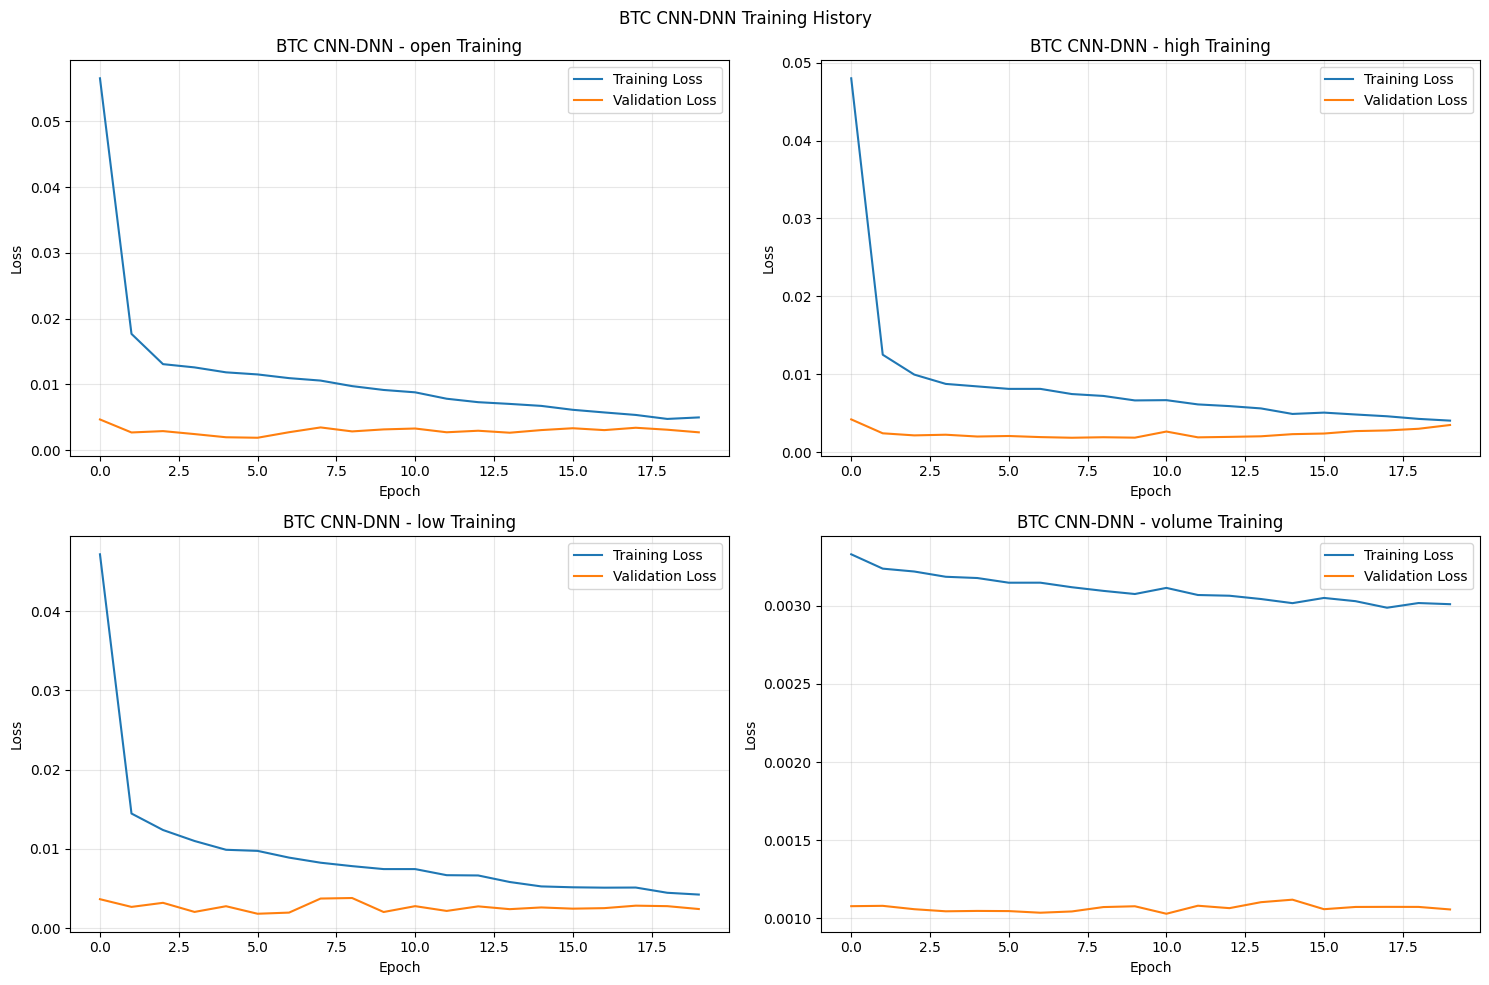


BTC CNN-DNN Training Performance:
           Model      RMSE       MAE        R²  Cosine_Similarity
0  CNN-DNN Train  0.056351  0.042526  0.937448           0.973255


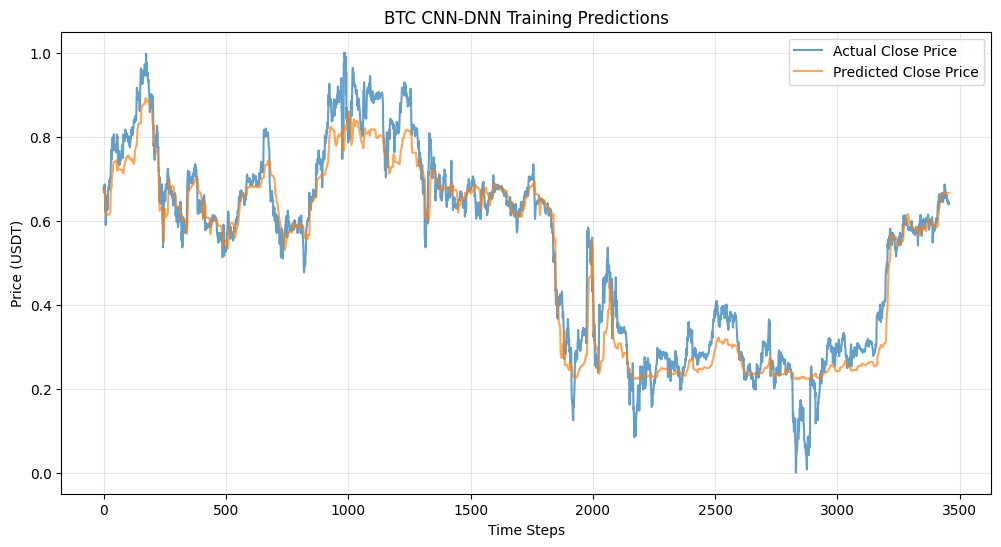


BTC CNN-DNN Test Performance:
          Model      RMSE       MAE        R²  Cosine_Similarity
0  CNN-DNN Test  0.078474  0.058365  0.866122           0.941027


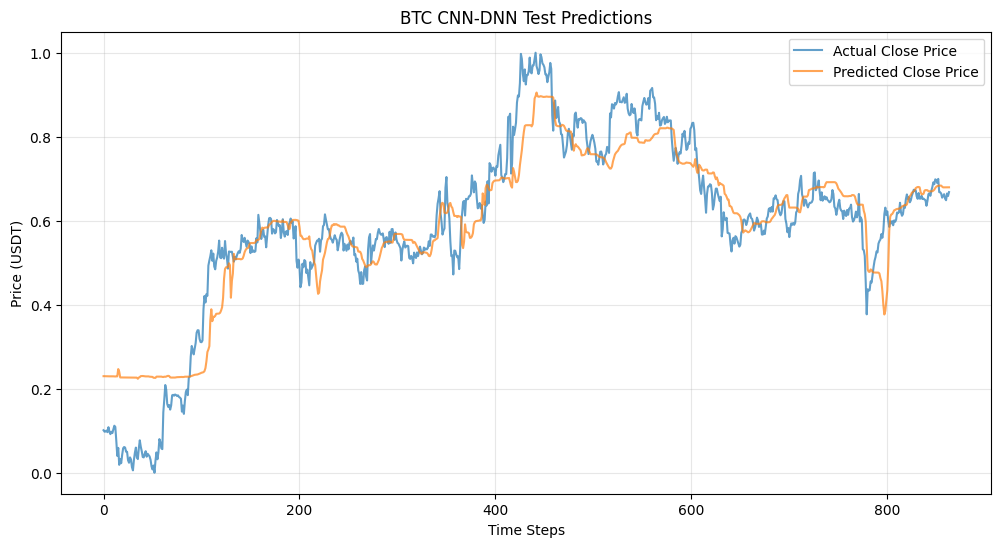


BTC CNN-DNN Cosine Similarity: 0.9410

Training CNN-BiGRU for BTC...
Train period: 2024-12-09 to 2025-05-03
Test period: 2025-05-03 to 2025-06-09
  Training CNN-BiGRU model for feature: open
  Training CNN-BiGRU model for feature: high
  Training CNN-BiGRU model for feature: low
  Training CNN-BiGRU model for feature: volume


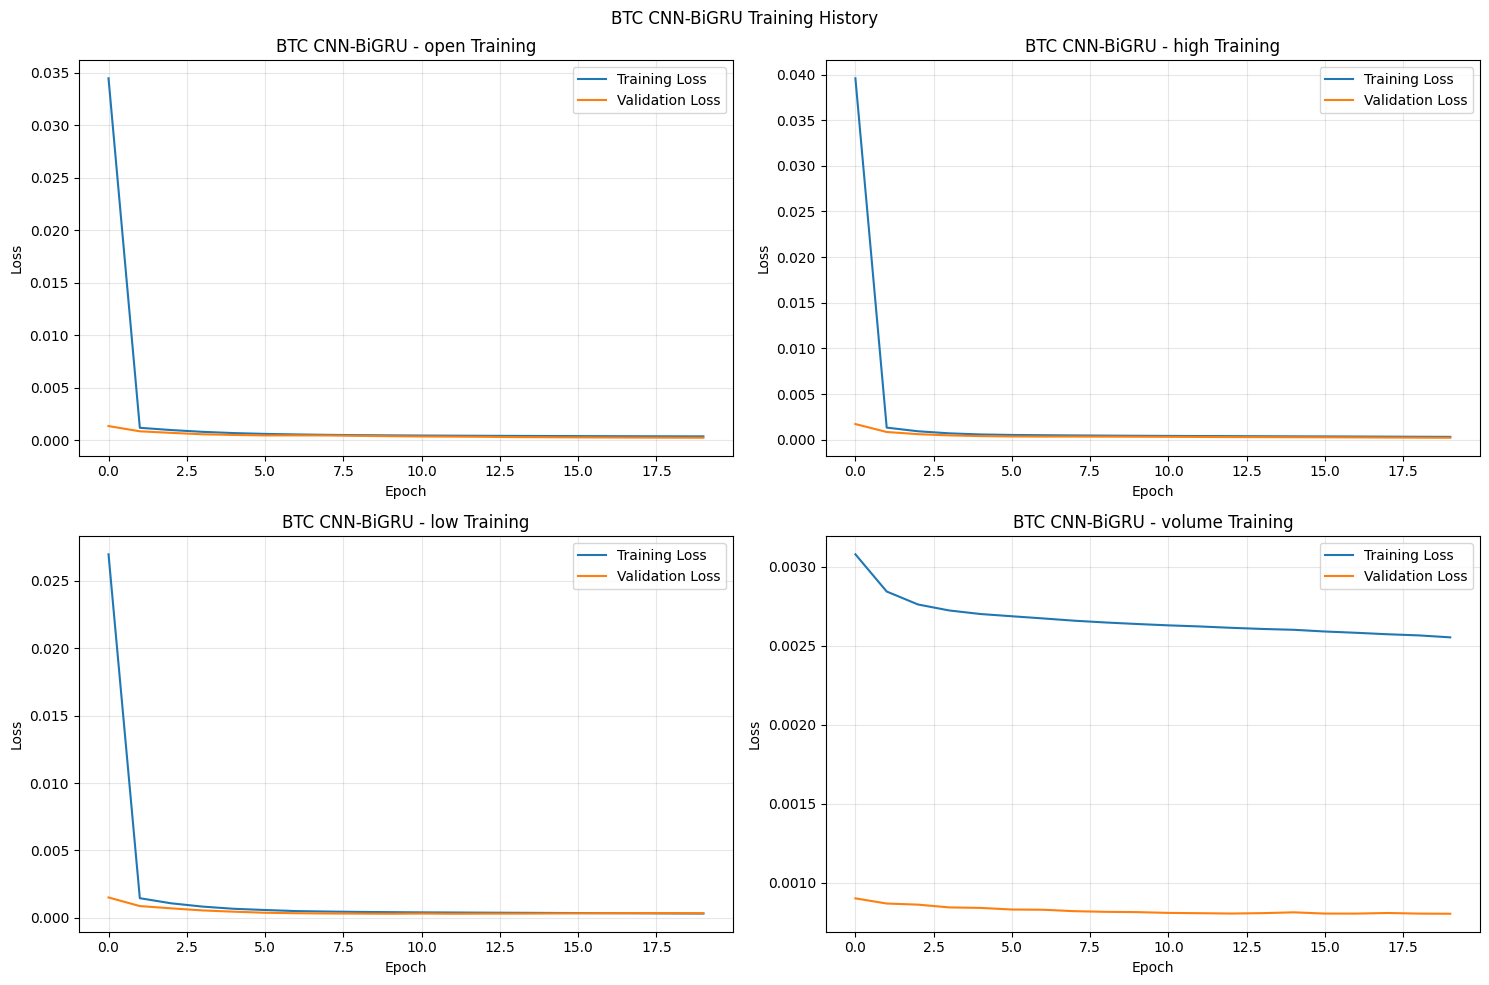


BTC CNN-BiGRU Training Performance:
             Model      RMSE       MAE        R²  Cosine_Similarity
0  CNN-BiGRU Train  0.044811  0.033658  0.960444           0.982121


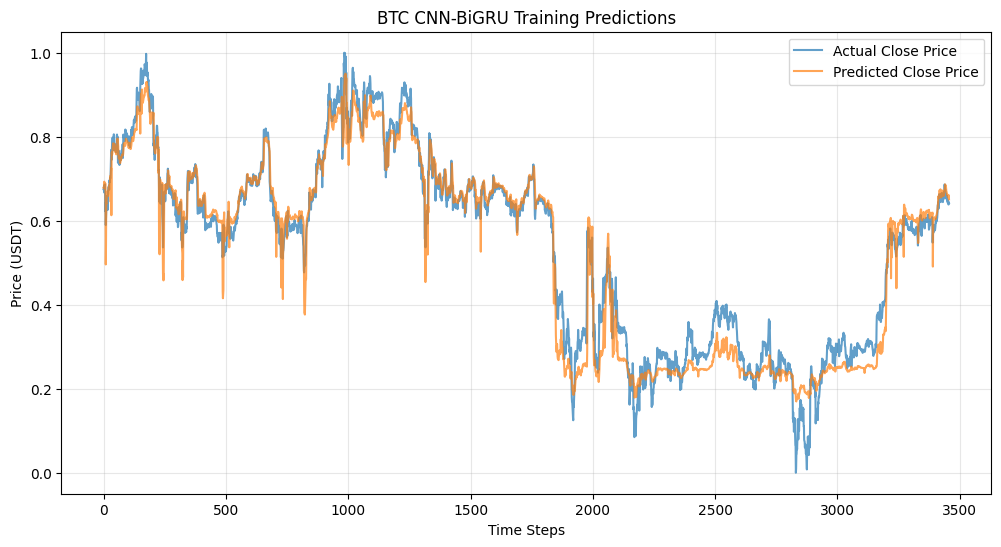


BTC CNN-BiGRU Test Performance:
            Model      RMSE       MAE        R²  Cosine_Similarity
0  CNN-BiGRU Test  0.059736  0.046052  0.922424           0.964588


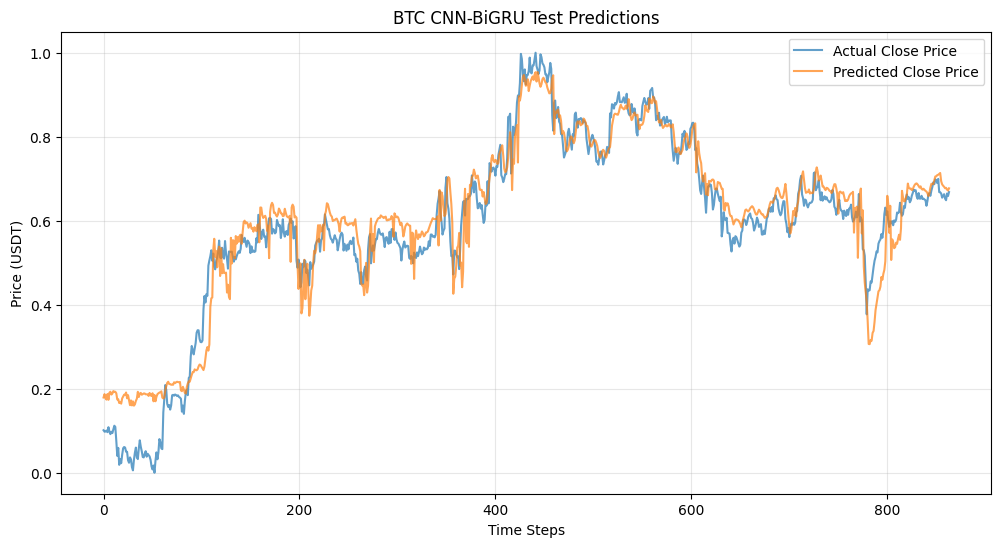


BTC CNN-BiGRU Cosine Similarity: 0.9646

Training TCN-DNN for BTC...
Train period: 2024-12-09 to 2025-05-03
Test period: 2025-05-03 to 2025-06-09
  Training TCN-DNN model for feature: open
  Training TCN-DNN model for feature: high
  Training TCN-DNN model for feature: low
  Training TCN-DNN model for feature: volume


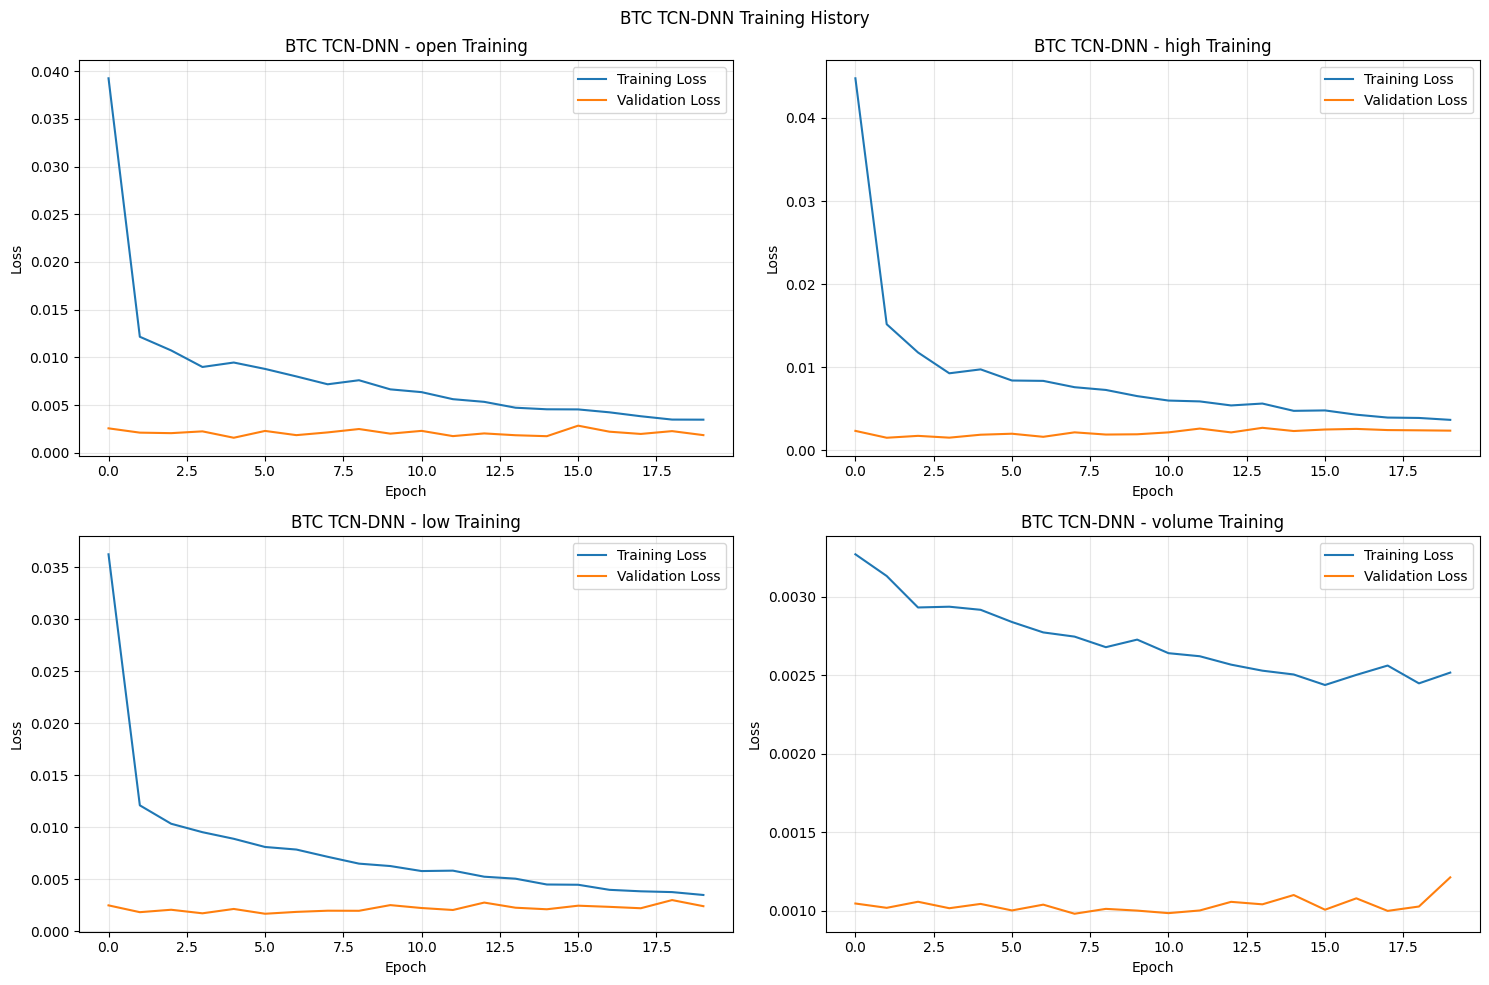


BTC TCN-DNN Training Performance:
           Model     RMSE       MAE        R²  Cosine_Similarity
0  TCN-DNN Train  0.04987  0.037137  0.951009           0.980501


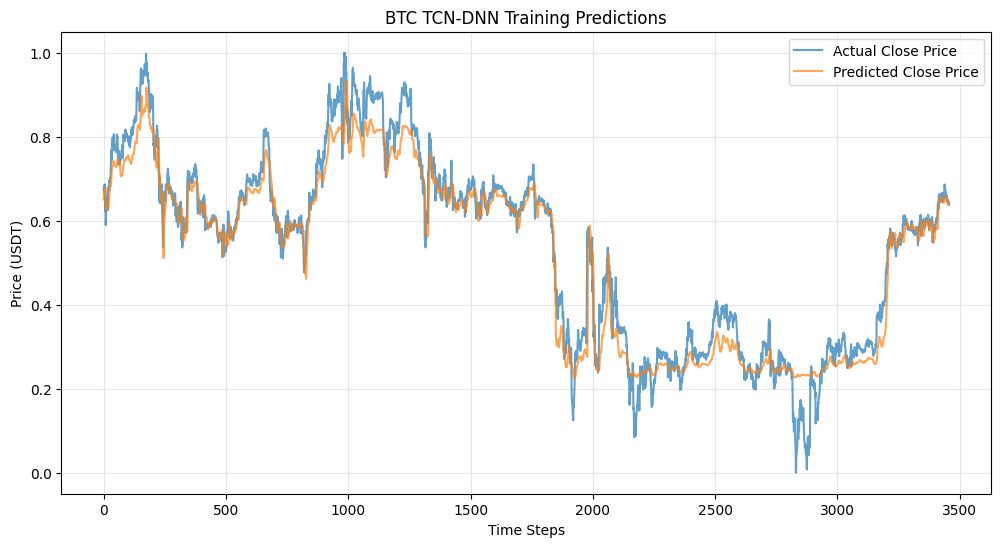


BTC TCN-DNN Test Performance:
          Model      RMSE       MAE        R²  Cosine_Similarity
0  TCN-DNN Test  0.070826  0.049185  0.890946           0.955837


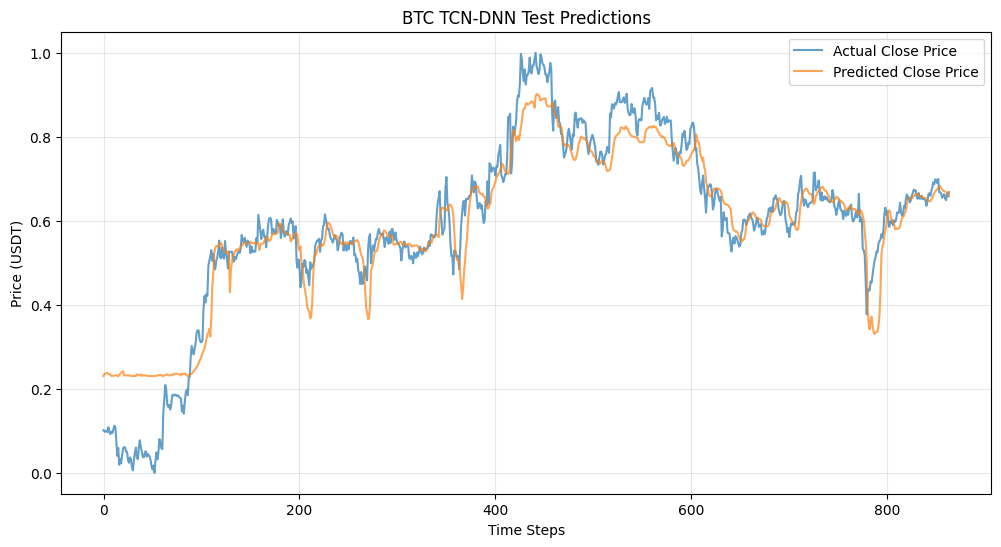


BTC TCN-DNN Cosine Similarity: 0.9558

Training TCN-BiGRU for BTC...
Train period: 2024-12-09 to 2025-05-03
Test period: 2025-05-03 to 2025-06-09
  Training TCN-BiGRU model for feature: open
  Training TCN-BiGRU model for feature: high
  Training TCN-BiGRU model for feature: low
  Training TCN-BiGRU model for feature: volume


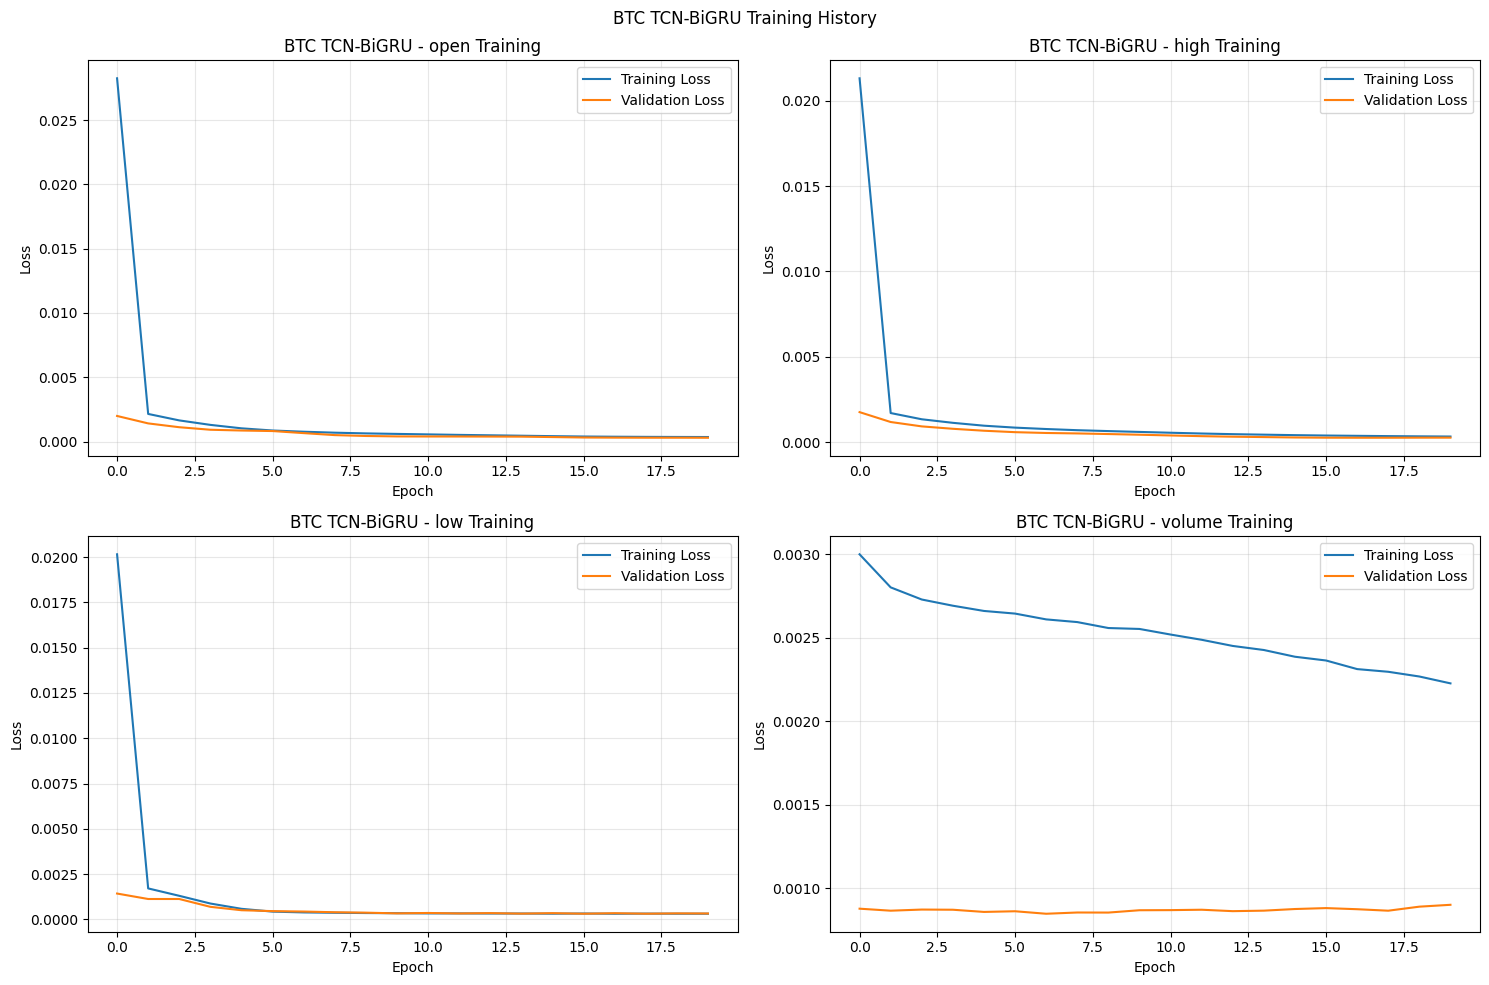


BTC TCN-BiGRU Training Performance:
             Model      RMSE       MAE        R²  Cosine_Similarity
0  TCN-BiGRU Train  0.036649  0.027407  0.973541           0.988102


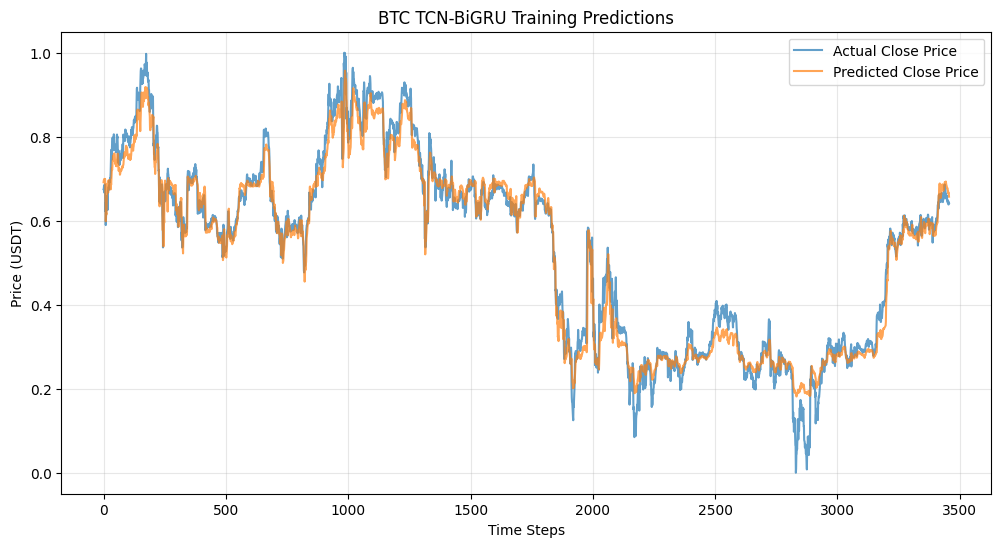


BTC TCN-BiGRU Test Performance:
            Model      RMSE       MAE        R²  Cosine_Similarity
0  TCN-BiGRU Test  0.051218  0.036844  0.942969           0.977675


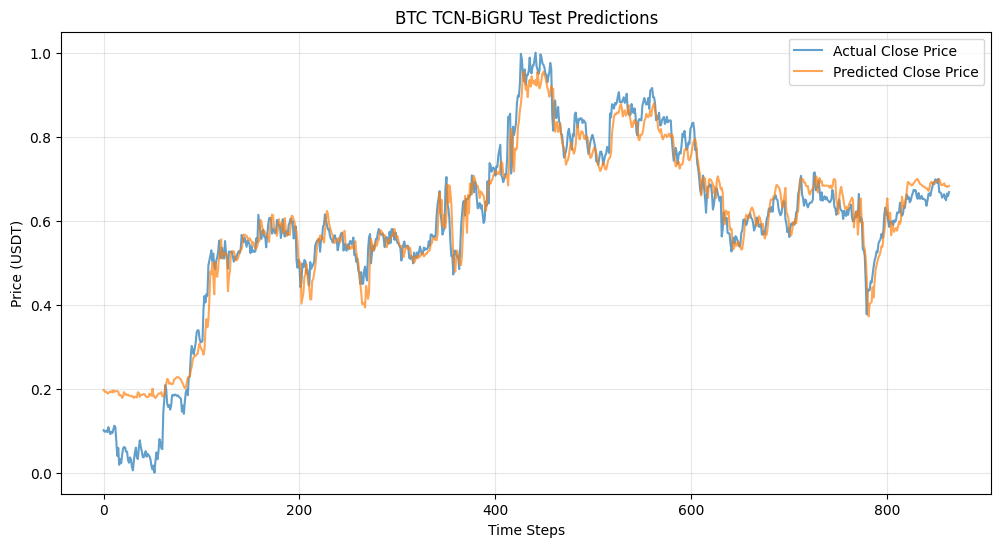


BTC TCN-BiGRU Cosine Similarity: 0.9777

PROCESSING CHZ

Training CNN-DNN for CHZ...
Train period: 2024-12-09 to 2025-05-03
Test period: 2025-05-03 to 2025-06-09
  Training CNN-DNN model for feature: open
  Training CNN-DNN model for feature: high
  Training CNN-DNN model for feature: low
  Training CNN-DNN model for feature: volume


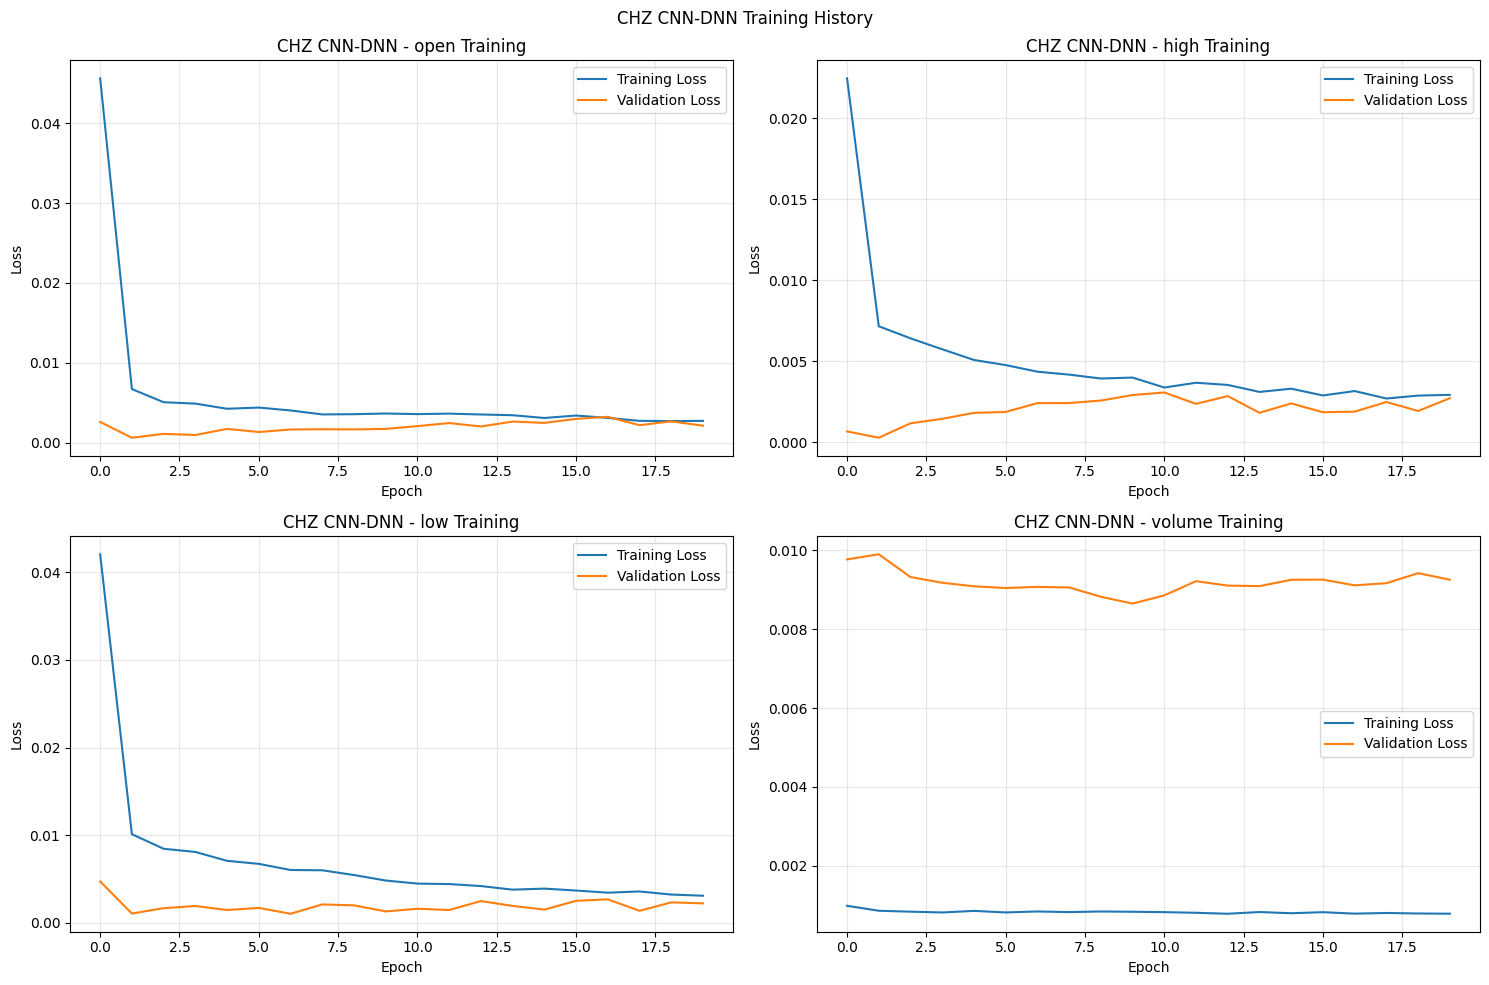


CHZ CNN-DNN Training Performance:
           Model      RMSE     MAE       R²  Cosine_Similarity
0  CNN-DNN Train  0.057423  0.0435  0.93923           0.988177


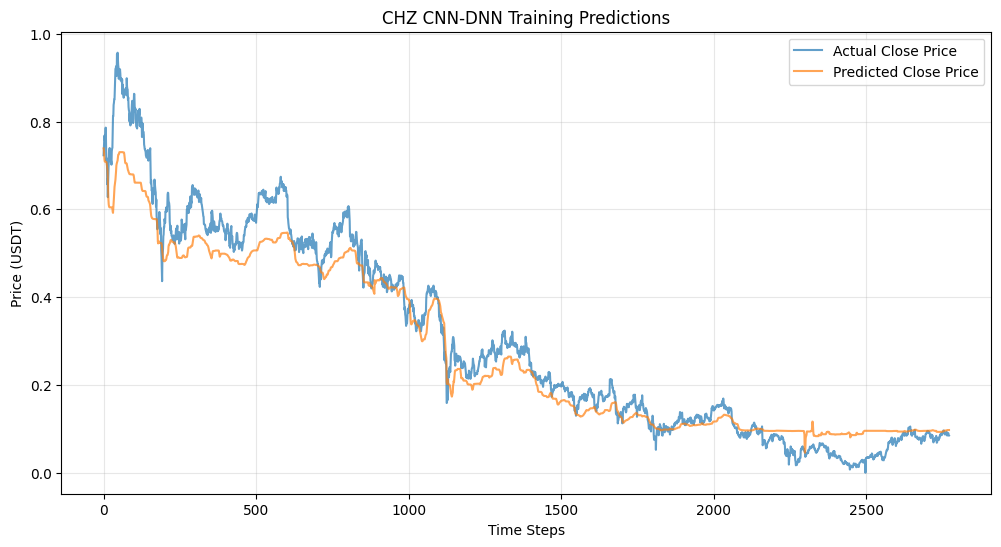


CHZ CNN-DNN Test Performance:
          Model      RMSE       MAE        R²  Cosine_Similarity
0  CNN-DNN Test  0.108409  0.086297  0.779178           0.922254


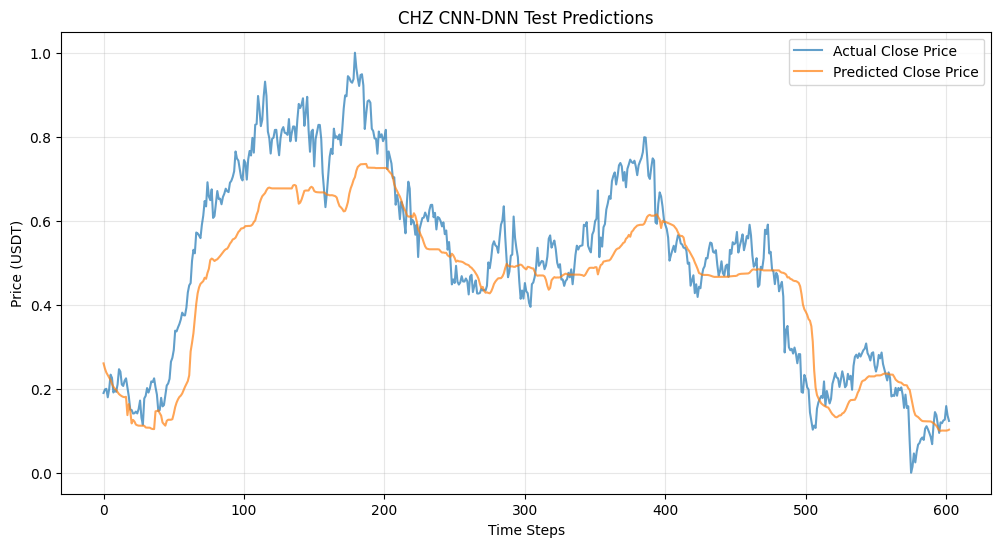


CHZ CNN-DNN Cosine Similarity: 0.9223

Training CNN-BiGRU for CHZ...
Train period: 2024-12-09 to 2025-05-03
Test period: 2025-05-03 to 2025-06-09
  Training CNN-BiGRU model for feature: open
  Training CNN-BiGRU model for feature: high
  Training CNN-BiGRU model for feature: low
  Training CNN-BiGRU model for feature: volume


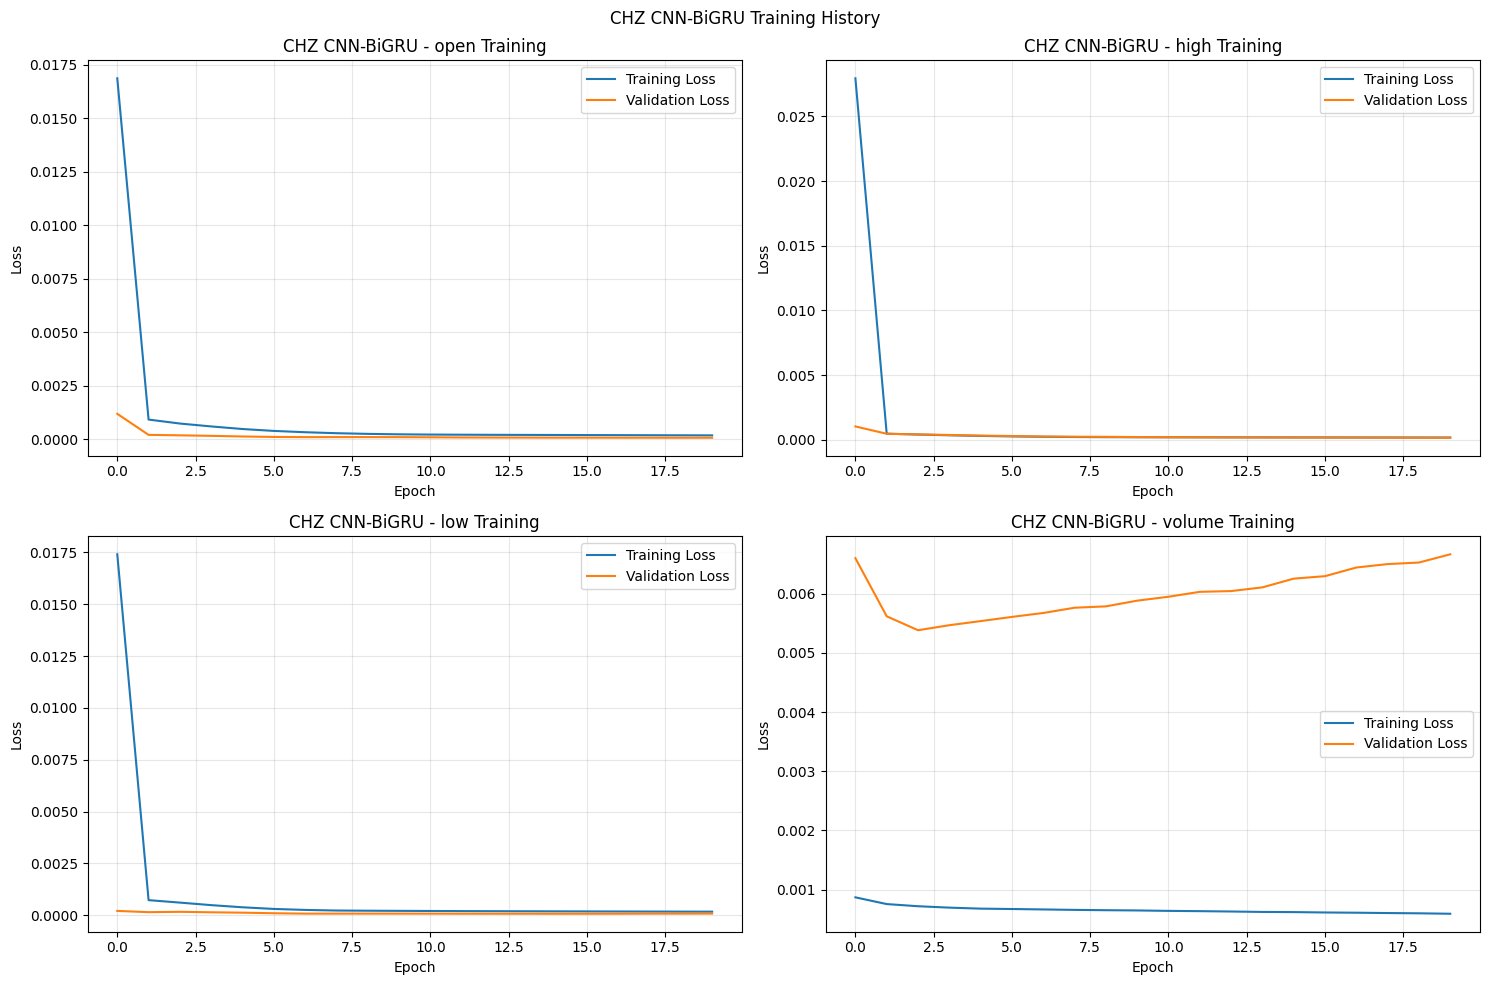


CHZ CNN-BiGRU Training Performance:
             Model      RMSE      MAE        R²  Cosine_Similarity
0  CNN-BiGRU Train  0.058321  0.04717  0.937316           0.989492


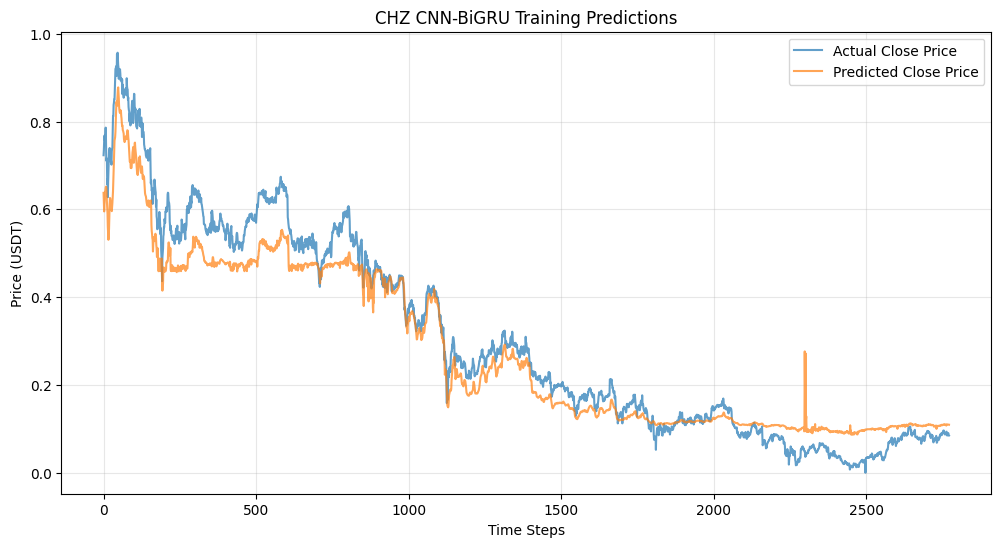


CHZ CNN-BiGRU Test Performance:
            Model      RMSE      MAE        R²  Cosine_Similarity
0  CNN-BiGRU Test  0.080938  0.06581  0.876914           0.976782


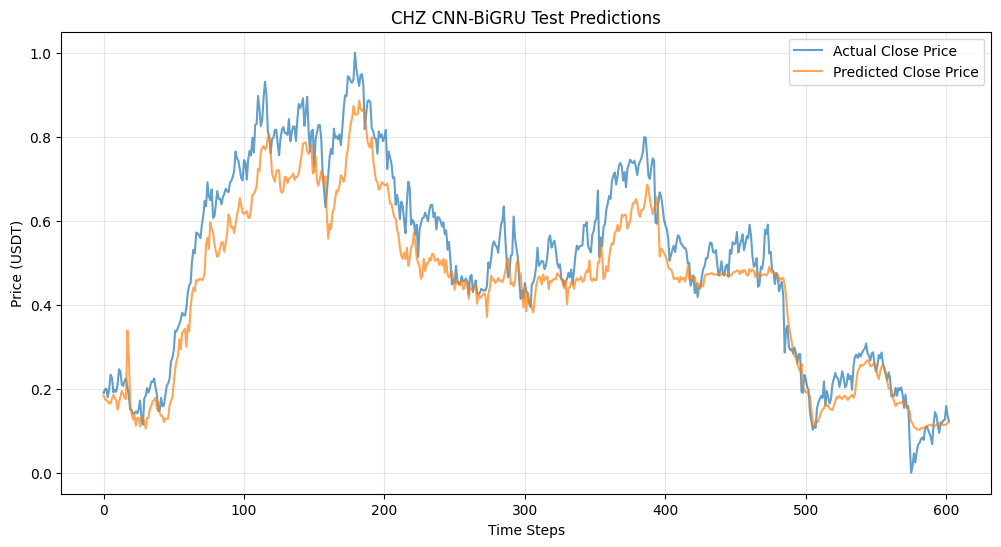


CHZ CNN-BiGRU Cosine Similarity: 0.9768

Training TCN-DNN for CHZ...
Train period: 2024-12-09 to 2025-05-03
Test period: 2025-05-03 to 2025-06-09
  Training TCN-DNN model for feature: open
  Training TCN-DNN model for feature: high
  Training TCN-DNN model for feature: low
  Training TCN-DNN model for feature: volume


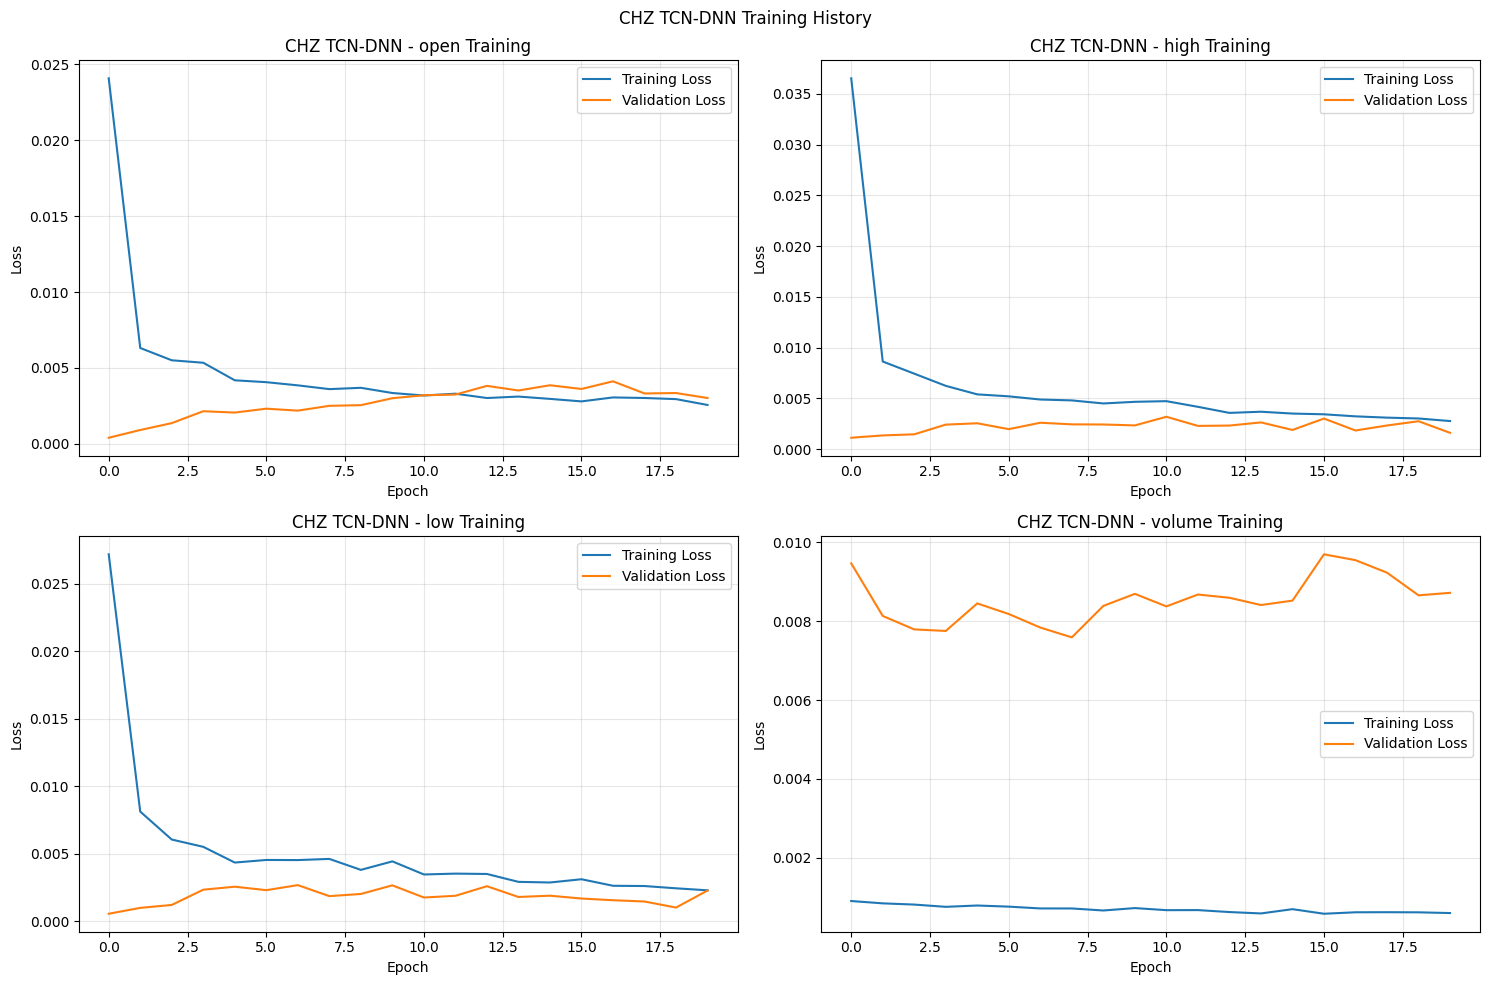


CHZ TCN-DNN Training Performance:
           Model      RMSE       MAE        R²  Cosine_Similarity
0  TCN-DNN Train  0.050684  0.041701  0.952657           0.989295


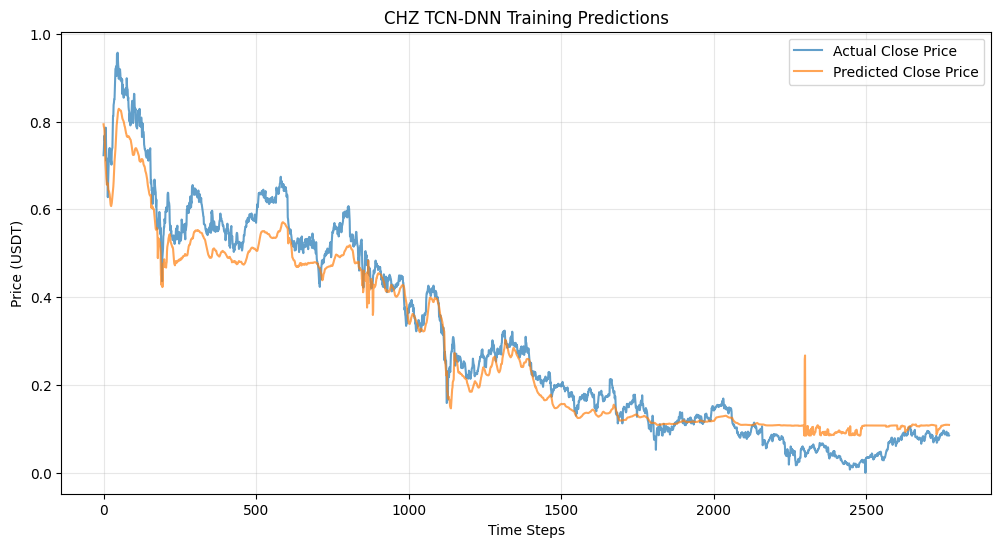


CHZ TCN-DNN Test Performance:
          Model      RMSE       MAE        R²  Cosine_Similarity
0  TCN-DNN Test  0.086356  0.068977  0.859883           0.952993


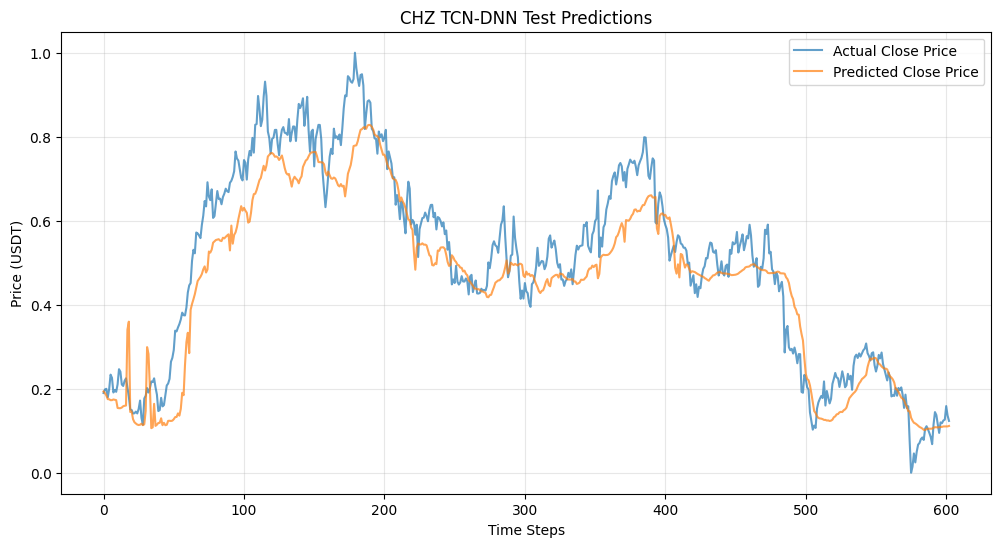


CHZ TCN-DNN Cosine Similarity: 0.9530

Training TCN-BiGRU for CHZ...
Train period: 2024-12-09 to 2025-05-03
Test period: 2025-05-03 to 2025-06-09
  Training TCN-BiGRU model for feature: open
  Training TCN-BiGRU model for feature: high
  Training TCN-BiGRU model for feature: low
  Training TCN-BiGRU model for feature: volume


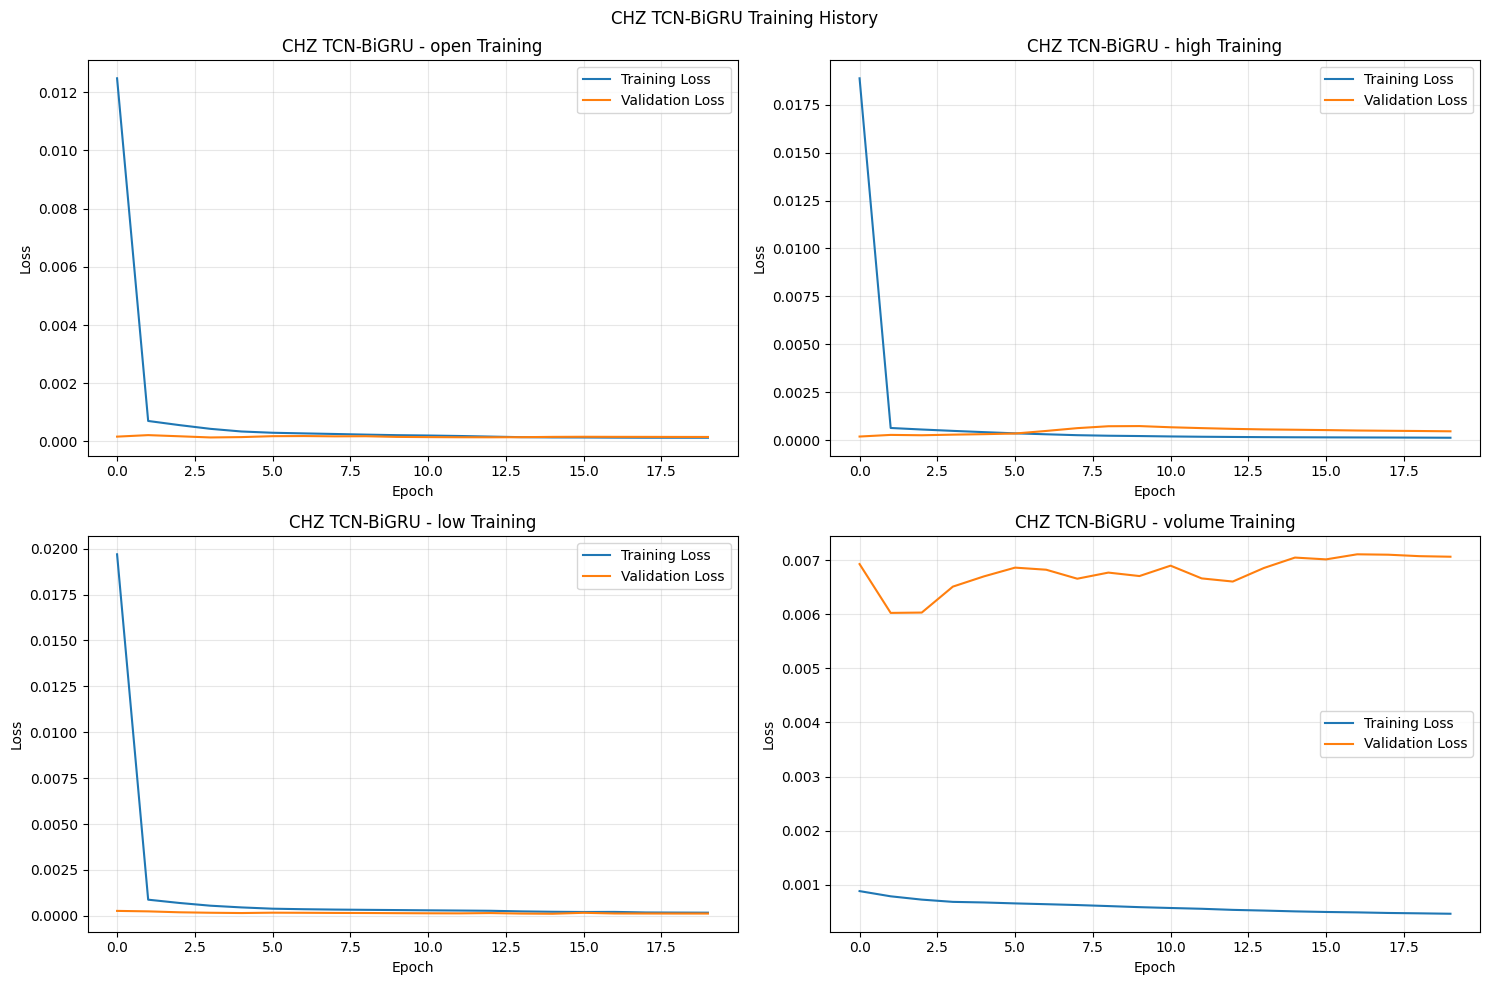


CHZ TCN-BiGRU Training Performance:
             Model     RMSE       MAE        R²  Cosine_Similarity
0  TCN-BiGRU Train  0.04806  0.037089  0.957432            0.99196


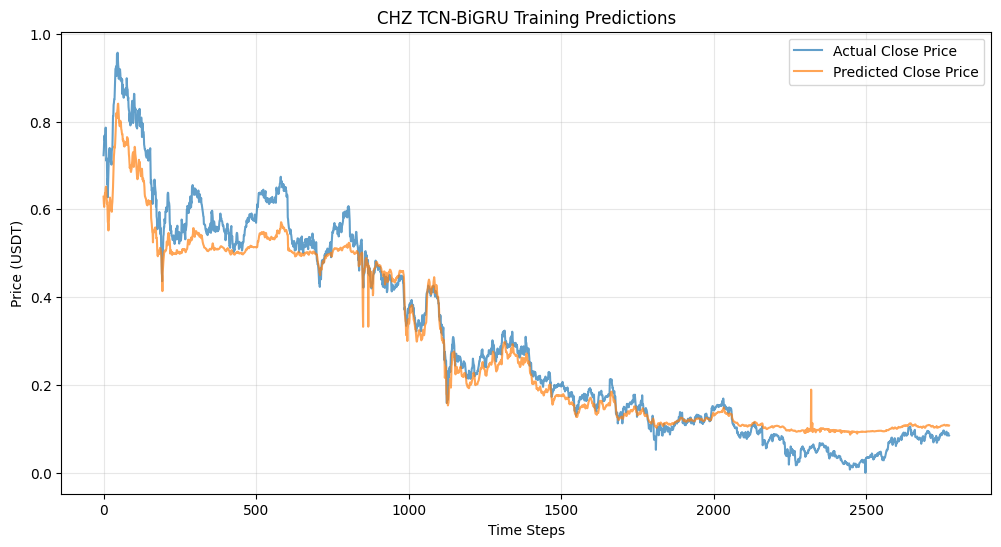


CHZ TCN-BiGRU Test Performance:
            Model     RMSE       MAE        R²  Cosine_Similarity
0  TCN-BiGRU Test  0.07098  0.055314  0.905338           0.979866


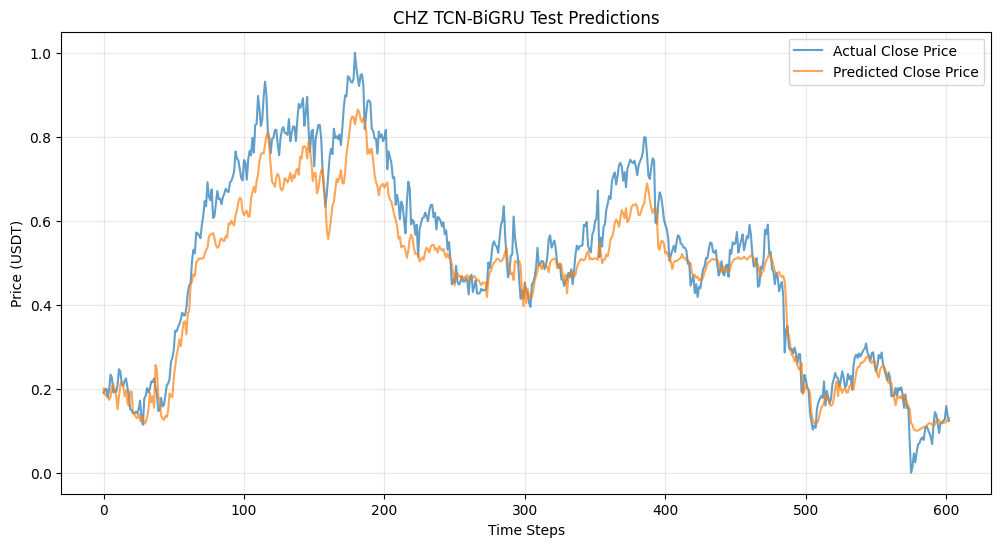


CHZ TCN-BiGRU Cosine Similarity: 0.9799

PROCESSING SUI

Training CNN-DNN for SUI...
Train period: 2024-12-09 to 2025-05-03
Test period: 2025-05-03 to 2025-06-09
  Training CNN-DNN model for feature: open
  Training CNN-DNN model for feature: high
  Training CNN-DNN model for feature: low
  Training CNN-DNN model for feature: volume


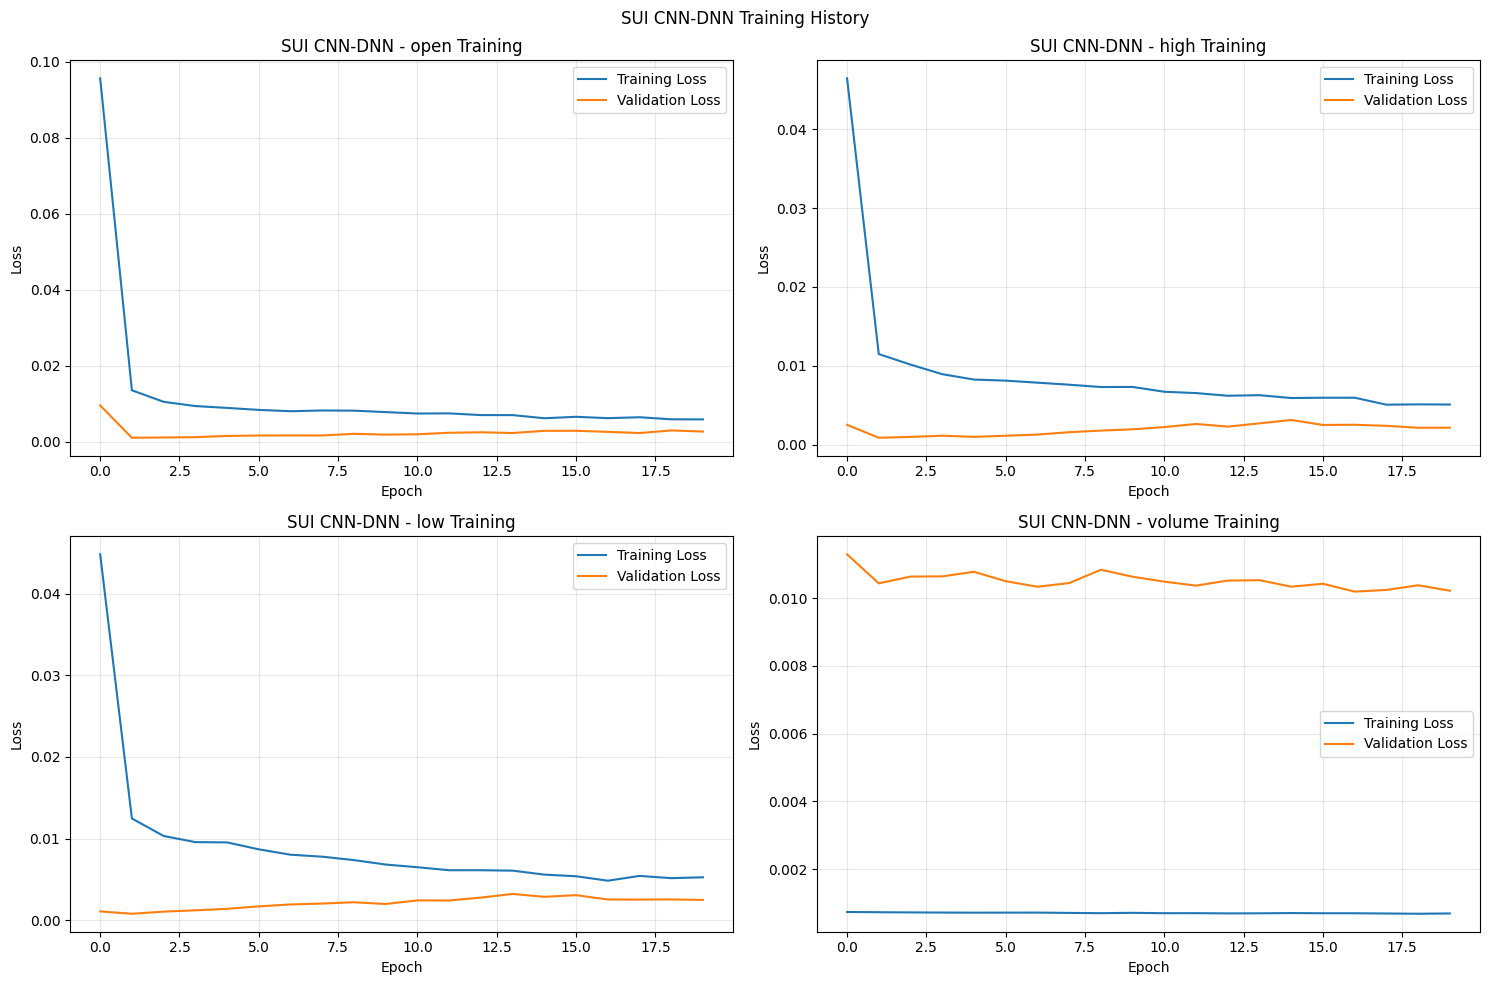


SUI CNN-DNN Training Performance:
           Model      RMSE       MAE     R²  Cosine_Similarity
0  CNN-DNN Train  0.054434  0.042198  0.959           0.981924


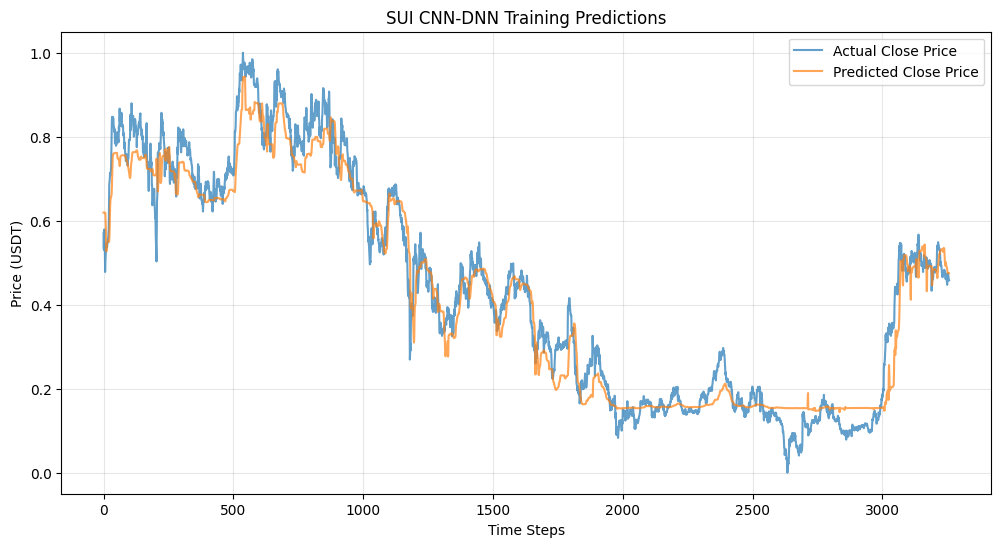


SUI CNN-DNN Test Performance:
          Model      RMSE       MAE        R²  Cosine_Similarity
0  CNN-DNN Test  0.094367  0.077195  0.830922           0.932506


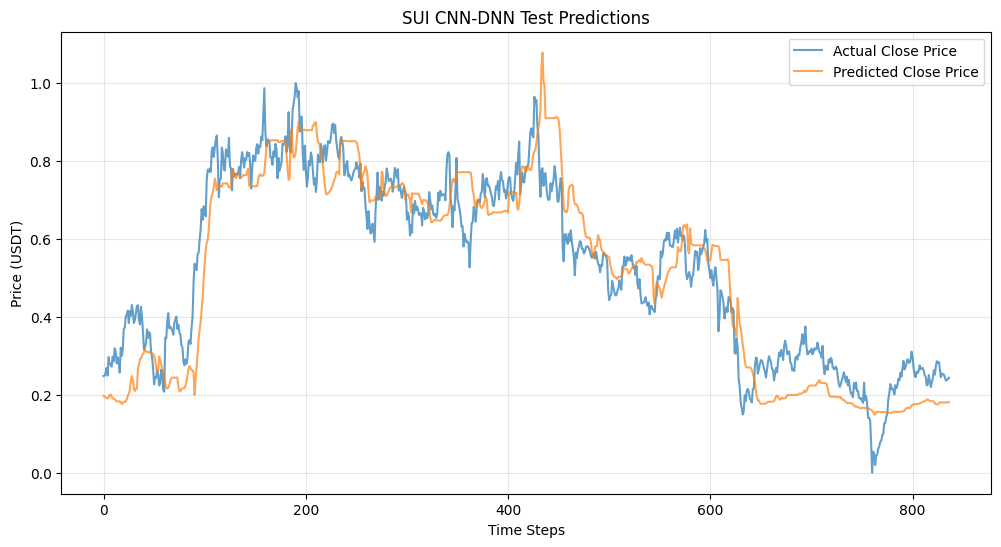


SUI CNN-DNN Cosine Similarity: 0.9325

Training CNN-BiGRU for SUI...
Train period: 2024-12-09 to 2025-05-03
Test period: 2025-05-03 to 2025-06-09
  Training CNN-BiGRU model for feature: open
  Training CNN-BiGRU model for feature: high
  Training CNN-BiGRU model for feature: low
  Training CNN-BiGRU model for feature: volume


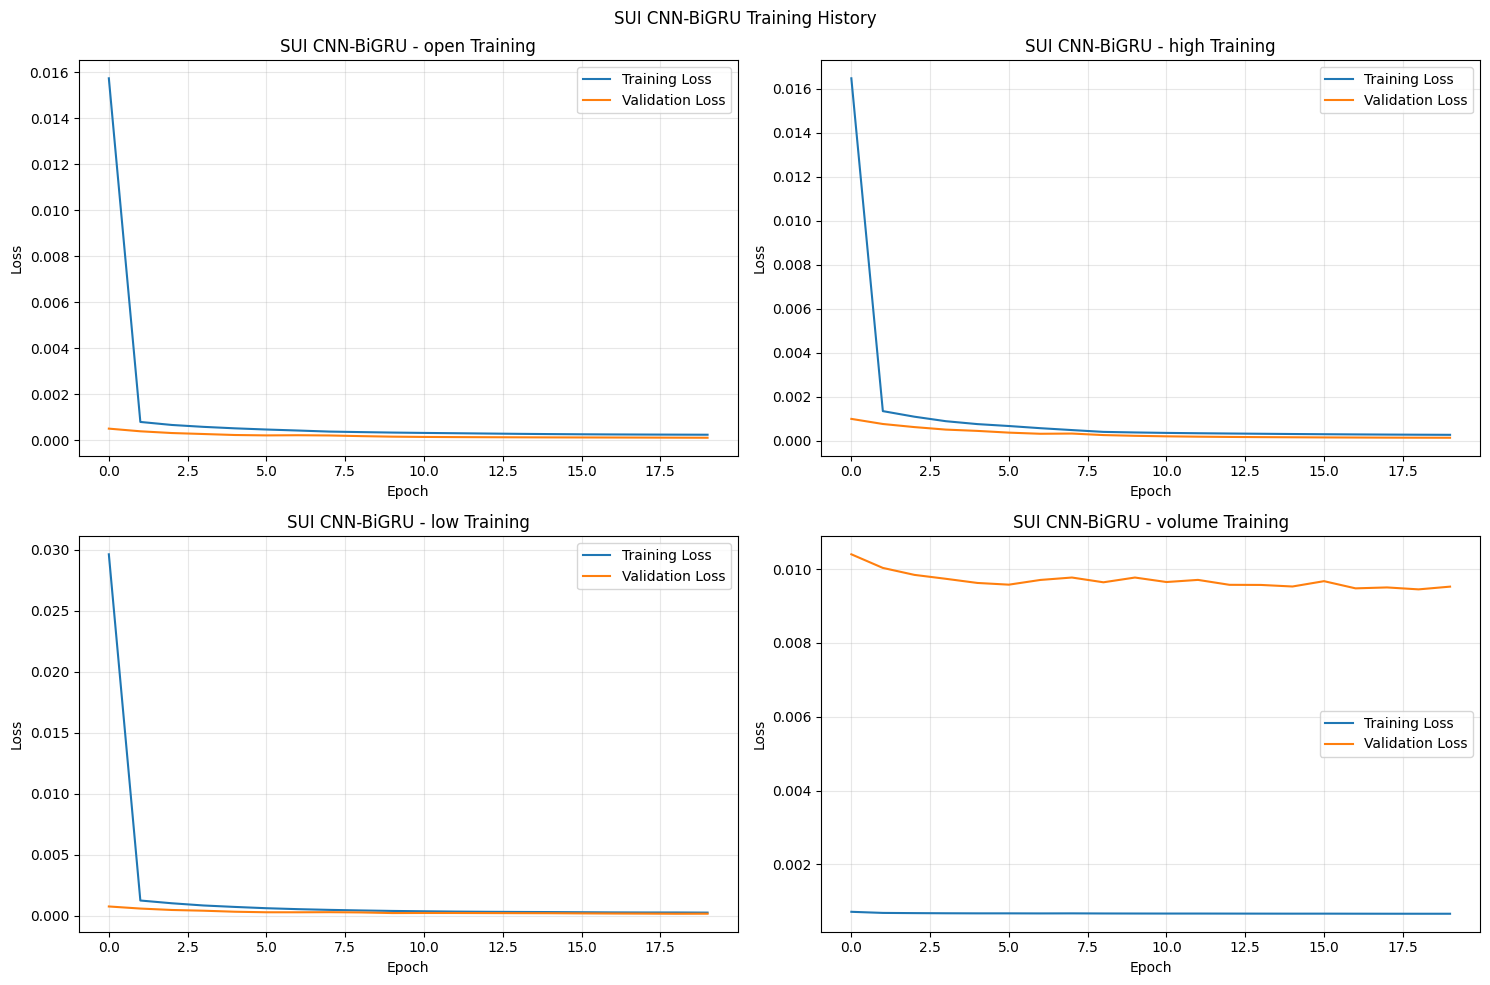


SUI CNN-BiGRU Training Performance:
             Model      RMSE       MAE        R²  Cosine_Similarity
0  CNN-BiGRU Train  0.038411  0.028989  0.979584           0.991951


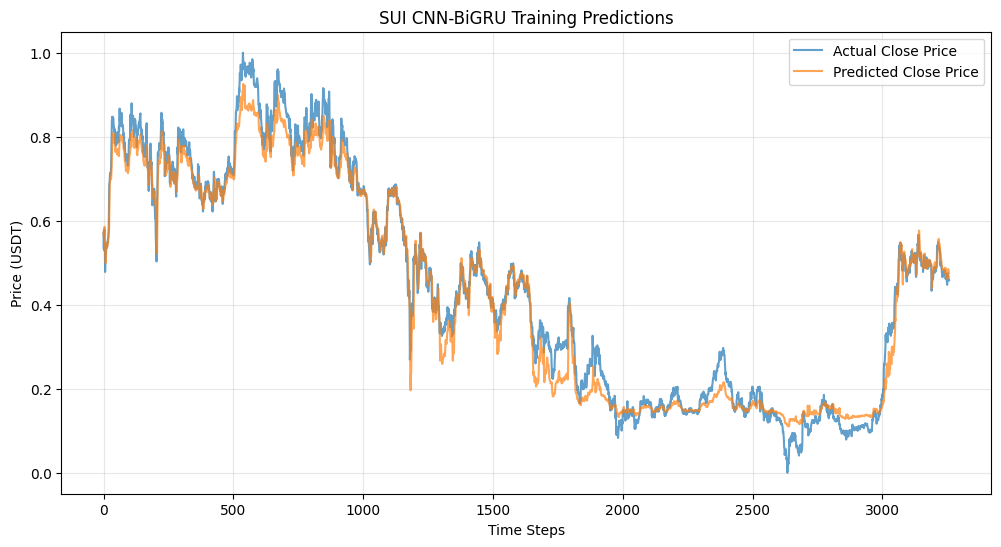


SUI CNN-BiGRU Test Performance:
            Model      RMSE       MAE        R²  Cosine_Similarity
0  CNN-BiGRU Test  0.061019  0.049764  0.929307           0.981367


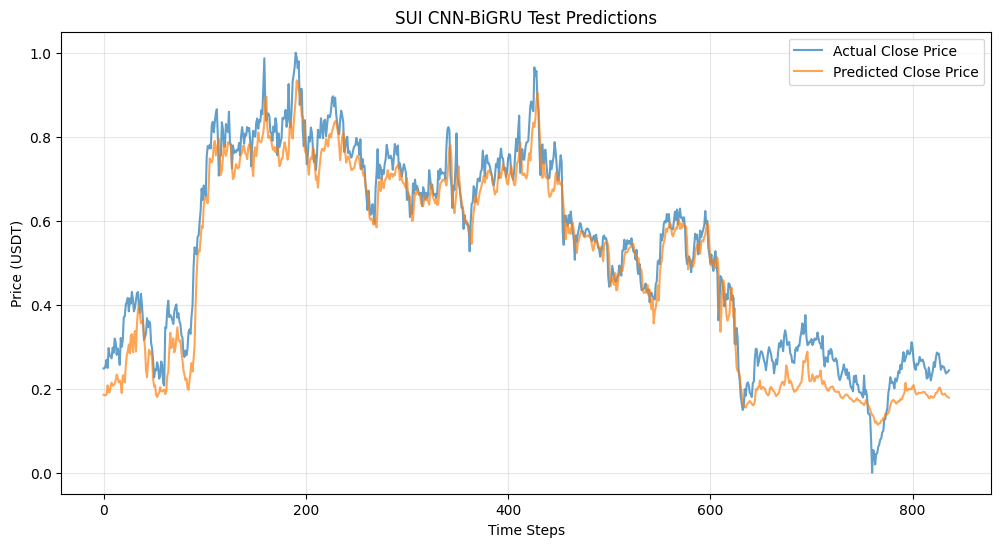


SUI CNN-BiGRU Cosine Similarity: 0.9814

Training TCN-DNN for SUI...
Train period: 2024-12-09 to 2025-05-03
Test period: 2025-05-03 to 2025-06-09
  Training TCN-DNN model for feature: open
  Training TCN-DNN model for feature: high
  Training TCN-DNN model for feature: low
  Training TCN-DNN model for feature: volume


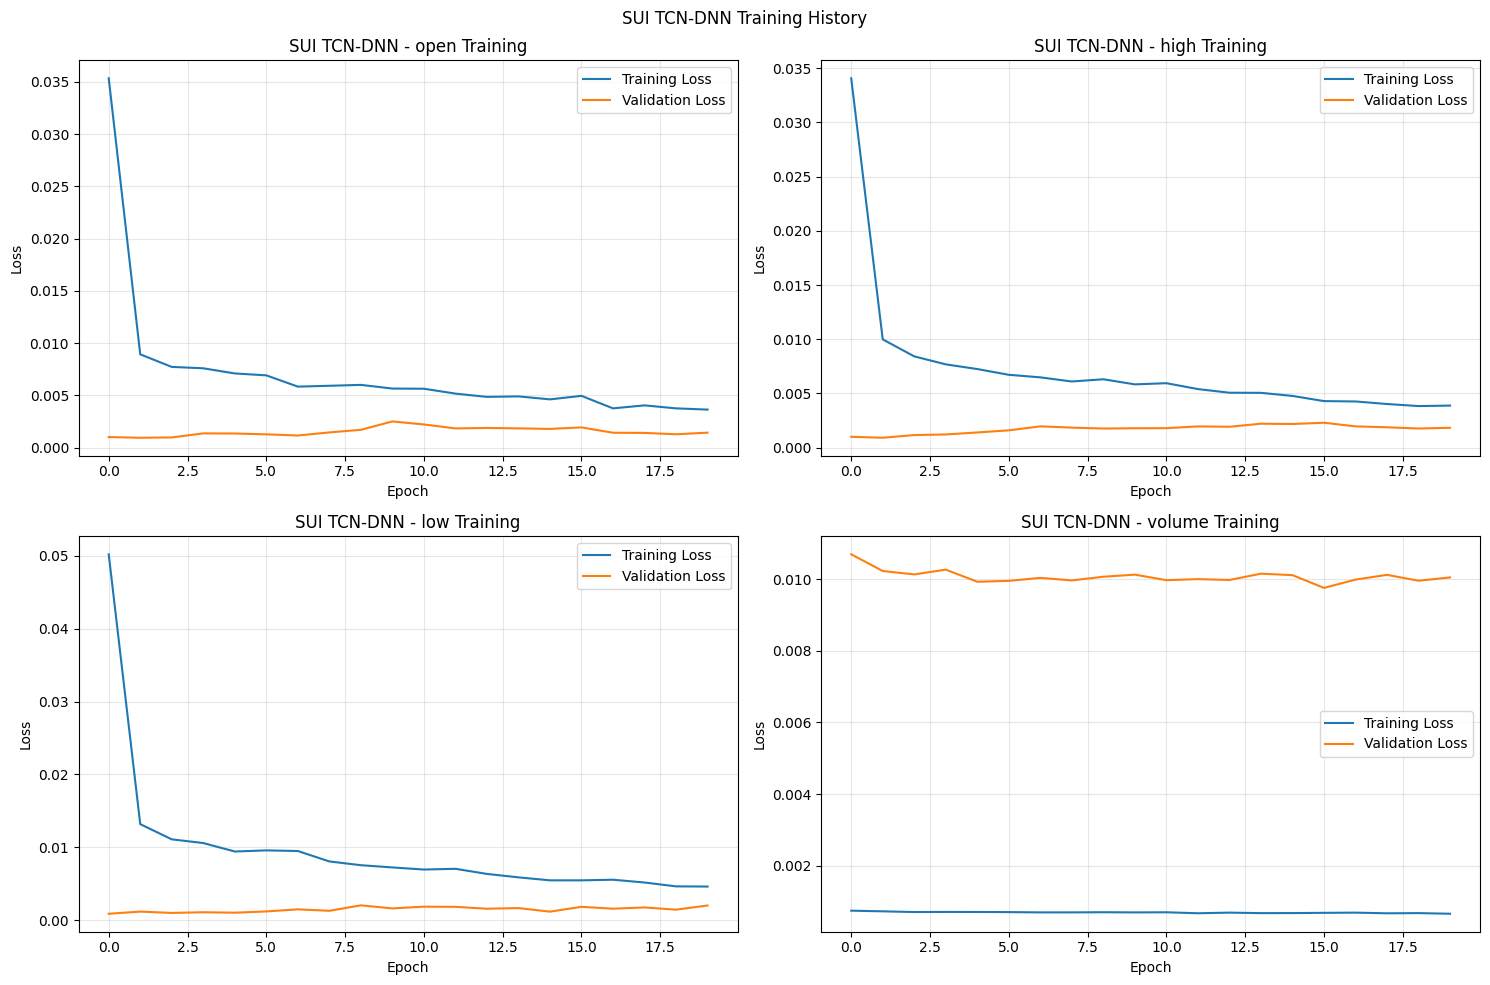


SUI TCN-DNN Training Performance:
           Model      RMSE       MAE        R²  Cosine_Similarity
0  TCN-DNN Train  0.045933  0.036277  0.970806           0.988278


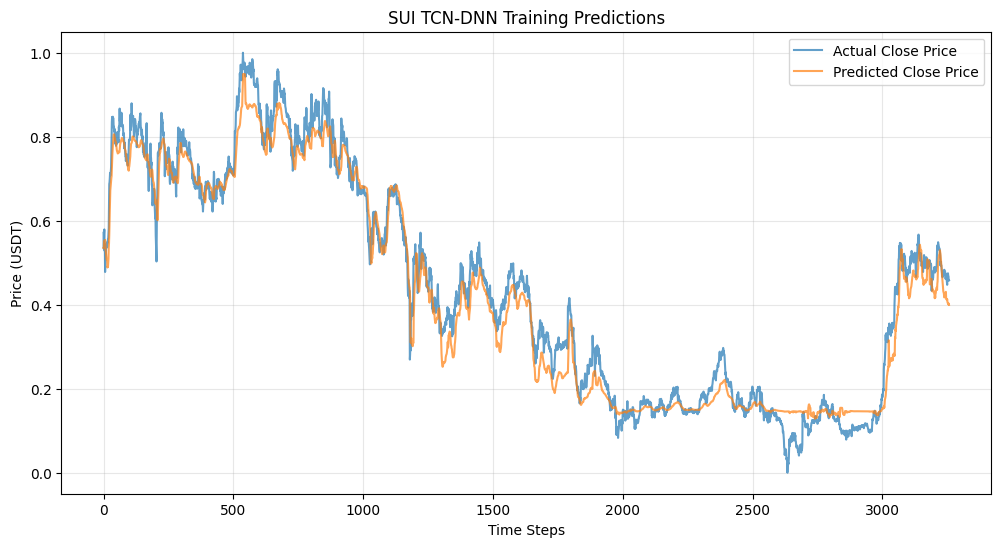


SUI TCN-DNN Test Performance:
          Model      RMSE       MAE        R²  Cosine_Similarity
0  TCN-DNN Test  0.069246  0.056717  0.908959           0.968928


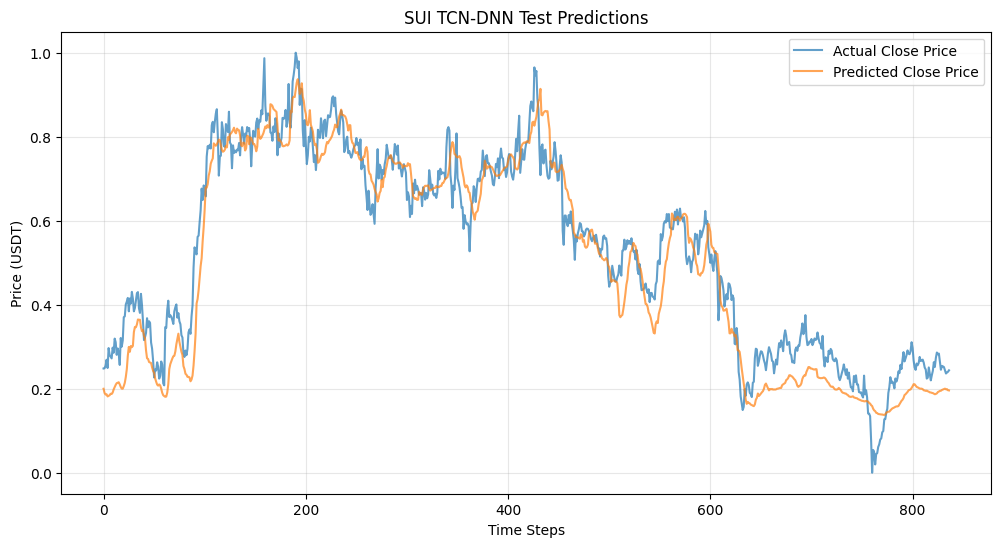


SUI TCN-DNN Cosine Similarity: 0.9689

Training TCN-BiGRU for SUI...
Train period: 2024-12-09 to 2025-05-03
Test period: 2025-05-03 to 2025-06-09
  Training TCN-BiGRU model for feature: open
  Training TCN-BiGRU model for feature: high
  Training TCN-BiGRU model for feature: low
  Training TCN-BiGRU model for feature: volume


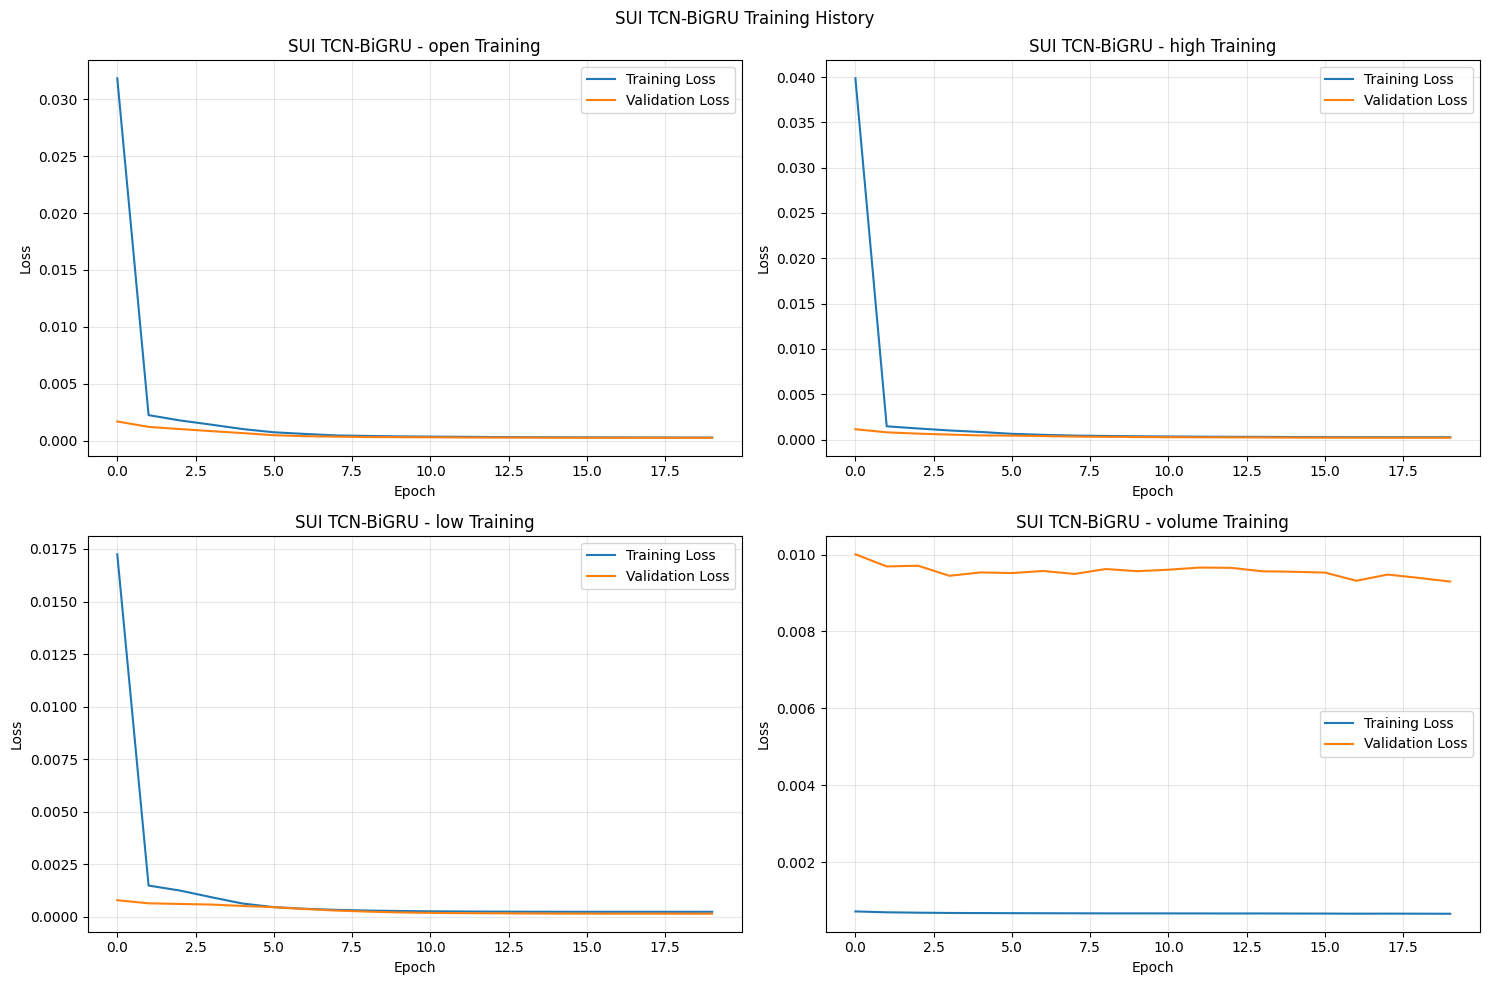


SUI TCN-BiGRU Training Performance:
             Model      RMSE       MAE        R²  Cosine_Similarity
0  TCN-BiGRU Train  0.042931  0.032425  0.974498           0.993028


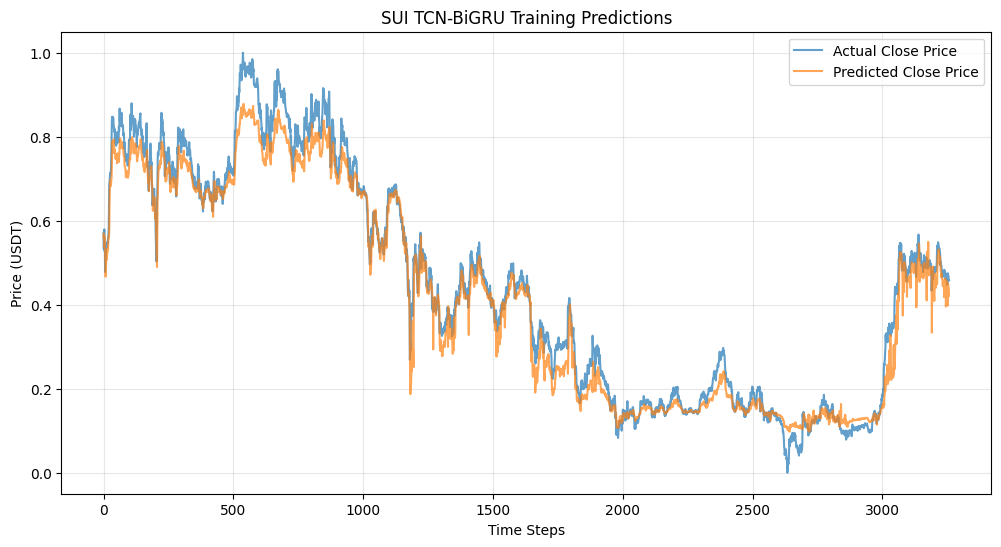


SUI TCN-BiGRU Test Performance:
            Model      RMSE      MAE        R²  Cosine_Similarity
0  TCN-BiGRU Test  0.073315  0.06211  0.897945           0.980616


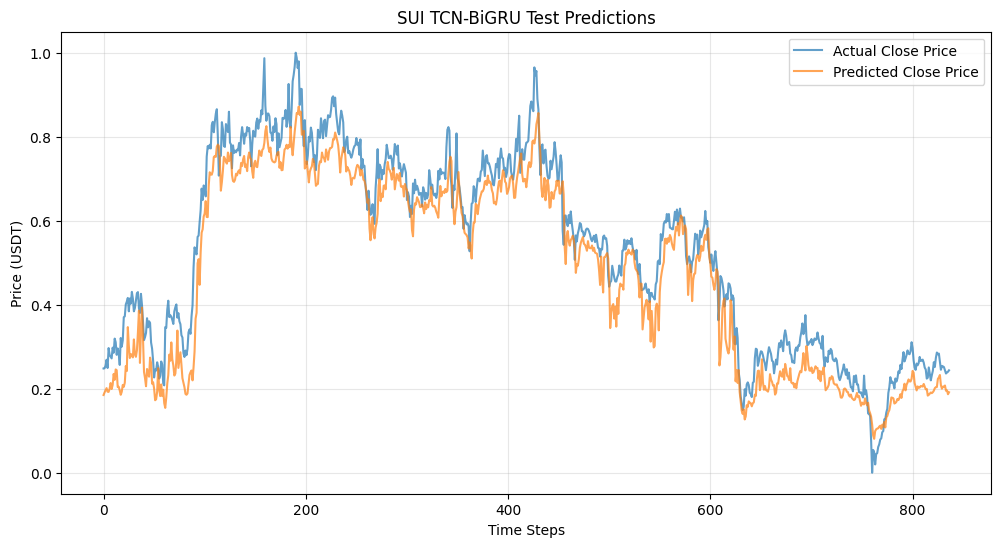


SUI TCN-BiGRU Cosine Similarity: 0.9806


In [17]:
print("Training All Models for All Cryptocurrencies")
print("="*60)

# Store all results
all_model_results = {}
model_types = ['CNN-DNN', 'CNN-BiGRU', 'TCN-DNN', 'TCN-BiGRU']

for coin_name, coin_data in processed_data.items():
    print(f"\n{'='*50}")
    print(f"PROCESSING {coin_name}")
    print(f"{'='*50}")

    all_model_results[coin_name] = {}

    for model_type in model_types:
        print(f"\nTraining {model_type} for {coin_name}...")
        result = train_single_model(coin_data, coin_name, model_type)
        all_model_results[coin_name][model_type] = result


Generating Final Performance Comparison...


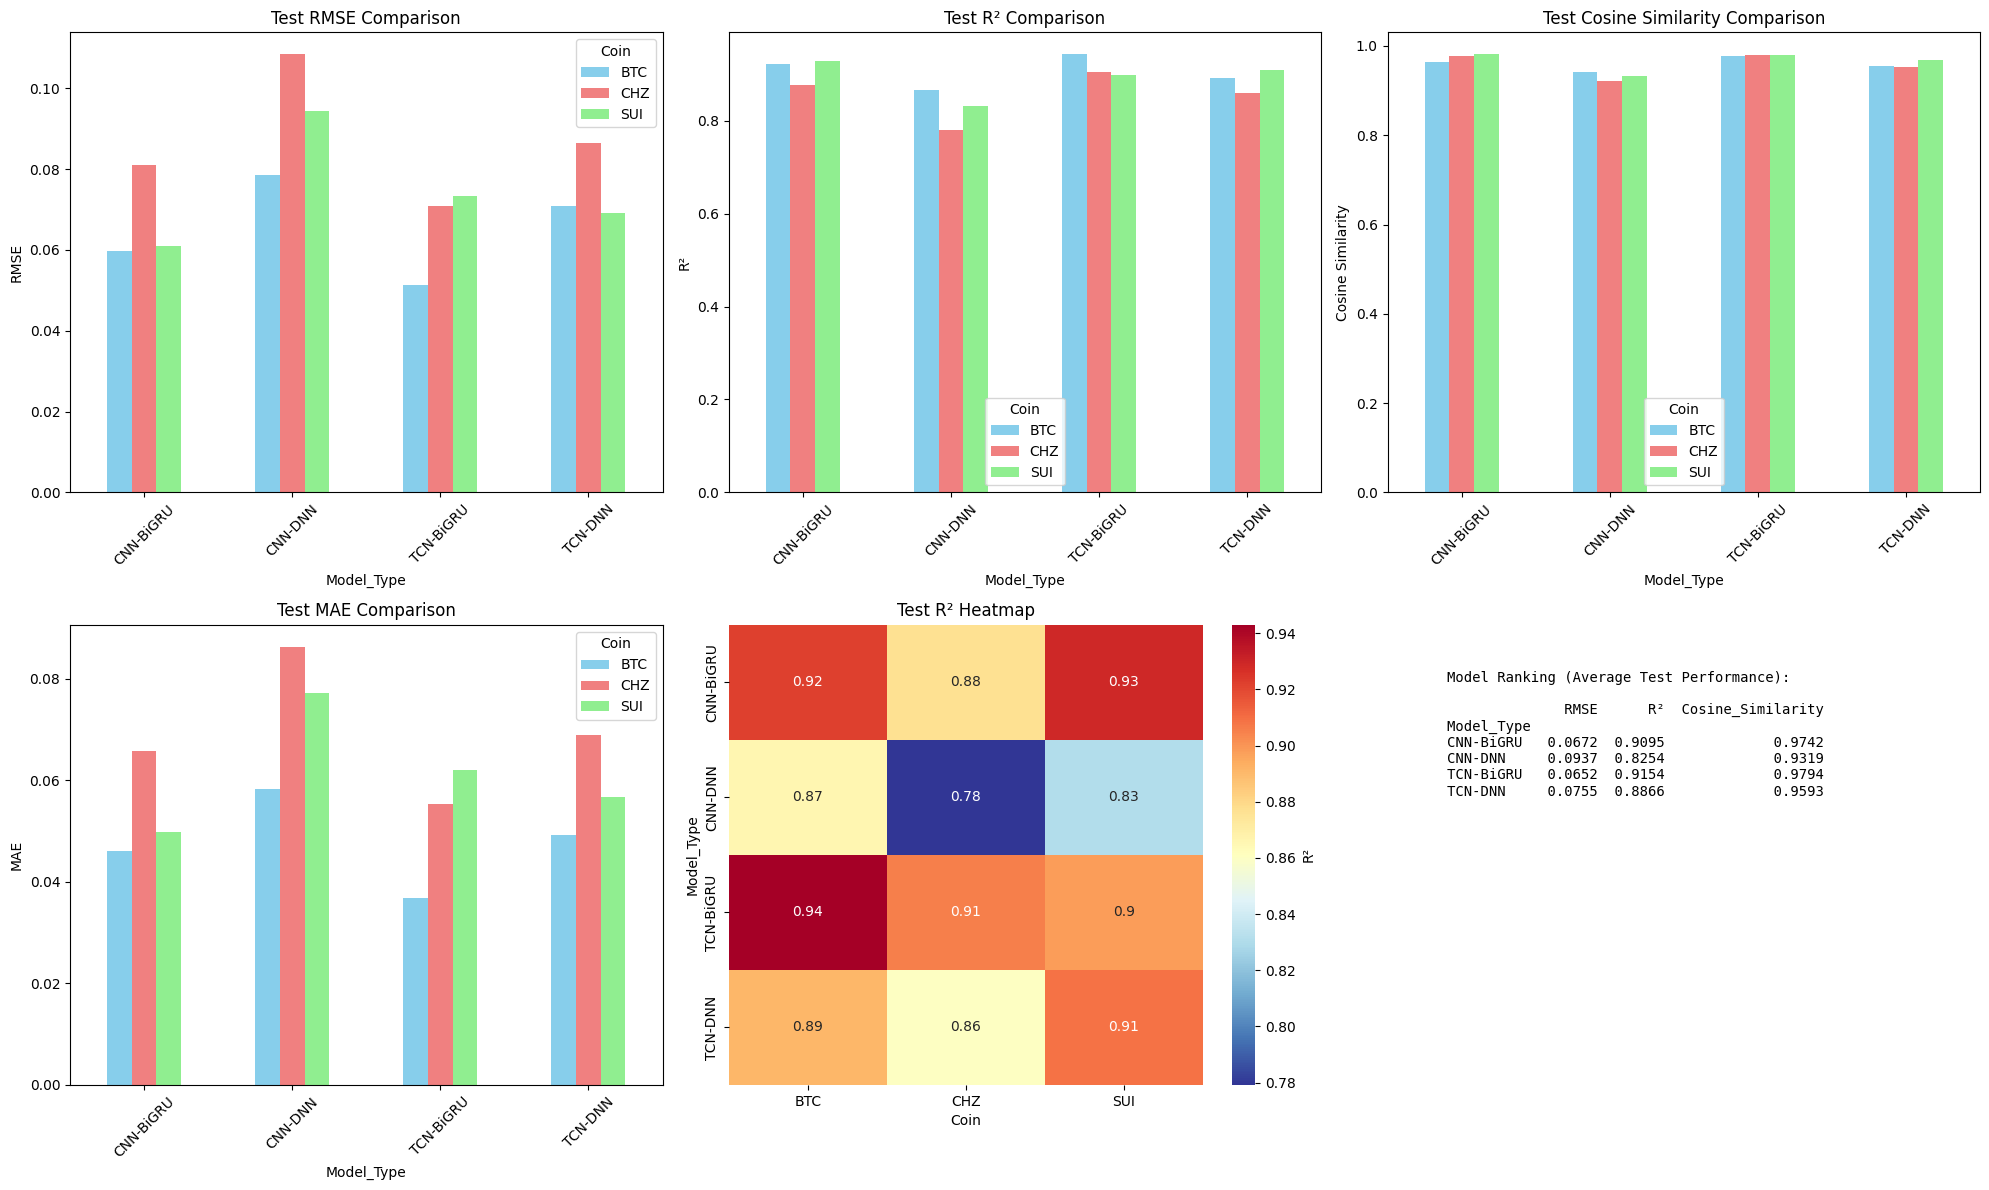


Summary Performance Table:


RMSE       MAE        R²  Cosine_Similarity
Coin Model_Type                                                 
BTC  CNN-BiGRU   0.059736  0.046052  0.922424           0.964588
     CNN-DNN     0.078474  0.058365  0.866122           0.941027
     TCN-BiGRU   0.051218  0.036844  0.942969           0.977675
     TCN-DNN     0.070826  0.049185  0.890946           0.955837
CHZ  CNN-BiGRU   0.080938  0.065810  0.876914           0.976782
     CNN-DNN     0.108409  0.086297  0.779178           0.922254
     TCN-BiGRU   0.070980  0.055314  0.905338           0.979866
     TCN-DNN     0.086356  0.068977  0.859883           0.952993
SUI  CNN-BiGRU   0.061019  0.049764  0.929307           0.981367
     CNN-DNN     0.094367  0.077195  0.830922           0.932506
     TCN-BiGRU   0.073315  0.062110  0.897945           0.980616
     TCN-DNN     0.069246  0.056717  0.908959           0.968928

In [19]:
def create_performance_comparison(all_results):
    """Create comprehensive performance comparison"""

    # Collect all metrics
    all_metrics = []

    for coin in all_results.keys():
        for model_name in all_results[coin].keys():
            result = all_results[coin][model_name]

            if result is None:
                continue

            # Train metrics
            if len(result['train_true']) > 0:
                train_metrics = evaluate_model(result['train_true'], result['train_pred'],
                                             f'{coin}_{model_name}')
                train_metrics['Dataset'] = 'Train'
                train_metrics['Coin'] = coin
                train_metrics['Model_Type'] = model_name
                all_metrics.append(train_metrics)

            # Test metrics
            if len(result['test_true']) > 0:
                test_metrics = evaluate_model(result['test_true'], result['test_pred'],
                                            f'{coin}_{model_name}')
                test_metrics['Dataset'] = 'Test'
                test_metrics['Coin'] = coin
                test_metrics['Model_Type'] = model_name
                all_metrics.append(test_metrics)

    if not all_metrics:
        print("No metrics to display")
        return pd.DataFrame()

    df_metrics = pd.DataFrame(all_metrics)

    # Create comparison visualizations
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # Filter test data
    test_data = df_metrics[df_metrics['Dataset'] == 'Test']

    if len(test_data) == 0:
        print("No test data to visualize")
        return df_metrics

    # RMSE bar plot
    try:
        pivot_rmse = test_data.pivot(index='Model_Type', columns='Coin', values='RMSE')
        pivot_rmse.plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[0,0].set_title('Test RMSE Comparison')
        axes[0,0].set_ylabel('RMSE')
        axes[0,0].legend(title='Coin')
        axes[0,0].tick_params(axis='x', rotation=45)
    except Exception as e:
        axes[0,0].set_title('RMSE - No Data')
        print(f"Error plotting RMSE: {e}")

    # R² bar plot
    try:
        pivot_r2 = test_data.pivot(index='Model_Type', columns='Coin', values='R²')
        pivot_r2.plot(kind='bar', ax=axes[0,1], color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[0,1].set_title('Test R² Comparison')
        axes[0,1].set_ylabel('R²')
        axes[0,1].legend(title='Coin')
        axes[0,1].tick_params(axis='x', rotation=45)
    except Exception as e:
        axes[0,1].set_title('R² - No Data')
        print(f"Error plotting R²: {e}")

    # Cosine Similarity bar plot
    try:
        pivot_cos = test_data.pivot(index='Model_Type', columns='Coin', values='Cosine_Similarity')
        pivot_cos.plot(kind='bar', ax=axes[0,2], color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[0,2].set_title('Test Cosine Similarity Comparison')
        axes[0,2].set_ylabel('Cosine Similarity')
        axes[0,2].legend(title='Coin')
        axes[0,2].tick_params(axis='x', rotation=45)
    except Exception as e:
        axes[0,2].set_title('Cosine Similarity - No Data')
        print(f"Error plotting Cosine Similarity: {e}")

    # MAE comparison
    try:
        pivot_mae = test_data.pivot(index='Model_Type', columns='Coin', values='MAE')
        pivot_mae.plot(kind='bar', ax=axes[1,0], color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[1,0].set_title('Test MAE Comparison')
        axes[1,0].set_ylabel('MAE')
        axes[1,0].legend(title='Coin')
        axes[1,0].tick_params(axis='x', rotation=45)
    except Exception as e:
        axes[1,0].set_title('MAE - No Data')
        print(f"Error plotting MAE: {e}")

    # Overall performance heatmap
    try:
        performance_matrix = test_data.pivot_table(
            index='Model_Type', columns='Coin', values='R²', aggfunc='mean')
        sns.heatmap(performance_matrix, annot=True, cmap='RdYlBu_r', ax=axes[1,1],
                    cbar_kws={'label': 'R²'})
        axes[1,1].set_title('Test R² Heatmap')
    except Exception as e:
        axes[1,1].set_title('R² Heatmap - No Data')
        print(f"Error plotting heatmap: {e}")

    # Model ranking
    try:
        model_ranking = test_data.groupby('Model_Type').agg({
            'RMSE': 'mean',
            'R²': 'mean',
            'Cosine_Similarity': 'mean'
        }).round(4)

        # Display ranking as text
        axes[1,2].axis('off')
        ranking_text = "Model Ranking (Average Test Performance):\n\n"
        ranking_text += model_ranking.to_string()
        axes[1,2].text(0.1, 0.9, ranking_text, transform=axes[1,2].transAxes,
                       fontsize=10, verticalalignment='top', fontfamily='monospace')
    except Exception as e:
        axes[1,2].axis('off')
        axes[1,2].text(0.5, 0.5, 'No ranking data available',
                       transform=axes[1,2].transAxes, ha='center', va='center')
        print(f"Error creating ranking: {e}")

    plt.tight_layout()
    plt.show()

    # Display summary table
    print("\nSummary Performance Table:")
    print("="*80)
    summary_table = test_data.groupby(['Coin', 'Model_Type']).agg({
        'RMSE': 'mean',
        'MAE': 'mean',
        'R²': 'mean',
        'Cosine_Similarity': 'mean'
    }).round(6)
    display(summary_table)

    return df_metrics

print("\nGenerating Final Performance Comparison...")
final_metrics = create_performance_comparison(all_model_results)